# Homework 4. Text Classification with CNN

Welcome to Homework 4! 

The homework contains several tasks. You can find the amount of points that you get for the correct solution in the task header. Maximum amount of points for each homework is _seven_ + _one_ bonus point.

The **grading** for each task is the following:
- correct answer - **full points**
- insufficient solution or solution resulting in the incorrect output - **half points**
- no answer or completely wrong solution - **no points**

Even if you don't know how to solve the task, we encourage you to write down your thoughts and progress and try to address the issues that stop you from completing the task.

When working on the written tasks, try to make your answers short and accurate. Most of the times, it is possible to answer the question in 1-3 sentences.

When writing code, make it readable. Choose appropriate names for your variables (`a = 'cat'` - not good, `word = 'cat'` - good). Avoid constructing lines of code longer than 100 characters (79 characters is ideal). If needed, provide the commentaries for your code, however, a good code should be easily readable without them :)

Finally, all your answers should be written only by yourself. If you copy them from other sources it will be considered as an academic fraud. You can discuss the tasks with your classmates but each solution must be individual.

<font color='red'>**Important!:**</font> **before sending your solution, do the `Kernel -> Restart & Run All` to ensure that all your code works.**

In [53]:
!pip install wandb

     |████████████████████████████████| 2.1MB 7.3MB/s 
     |████████████████████████████████| 102kB 13.8MB/s 
     |████████████████████████████████| 133kB 35.5MB/s 
     |████████████████████████████████| 163kB 35.2MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=78f3bc1848d87878b190a0f706d85bbb109aad2224a44ca01d64e5b483c11eed
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=6f0ad090f08811f4b25596cb72bf3d7e2c69b32ba5465fd46da9484f53cd0112
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


In [54]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [55]:
import wandb

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np

from pathlib import Path
import time
import json

# from: https://spacy.io/api/tokenizer
from spacy.lang.en import English
nlp = English()
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
tokenizer = nlp.Defaults.create_tokenizer(nlp)

# Check if we are running on a CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## About the homework

This homework is based on the [Lab 5]. You can freely use all the code and materials from this Lab to solve this homework. 

In the Lab, we looked at the binary classification problem. In other words, we had to predict only two classes. In this homework, you are going to learn about multi-label classification. This means that predictions can contain various number of labels. For exapmle, one movie can be drama, action, and murder at the same time while some other movie is just comedy. We achieve this by transforming the task into multiple binary classification problems. Basically, we are saying for each label if it is present or not.

This will require for you to change the data loader and the model. We are going to introduce new metrics to evaluate the model as well.

This time, you are going to work with [MPST: A Corpus of Movie Plot Synopses with Tags](http://ritual.uh.edu/mpst-2018/), the same dataset that we used in the previous Homework.

__We strongly recommend you to do this homework in Google Colab if you don't have a GPU on your machine!__

## Task 0. Download the data (0 points)

Let's download the vector file and unpack in to the `vector_cache/` folder. You can skip this step if you have already done it yourself.

In [14]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2021-04-02 10:22:37--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip.1’

wiki-news-300d-1M.v 100%[===================>] 650.22M  68.5MB/s    in 11s     

2021-04-02 10:22:48 (61.4 MB/s) - ‘wiki-news-300d-1M.vec.zip.1’ saved [681808098/681808098]



In [15]:
!unzip wiki-news-300d-1M.vec.zip -d vector_cache/

Archive:  wiki-news-300d-1M.vec.zip
replace vector_cache/wiki-news-300d-1M.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: vector_cache/wiki-news-300d-1M.vec  



Let's download the dataset and unpack in to the `MPST/` folder. You can skip this step if you have already done it yourself.

In [16]:
!wget http://ritual.uh.edu/wp-content/uploads/projects/mpst_2018/MPST.7z

--2021-04-02 10:33:32--  http://ritual.uh.edu/wp-content/uploads/projects/mpst_2018/MPST.7z
Resolving ritual.uh.edu (ritual.uh.edu)... 129.7.248.228
Connecting to ritual.uh.edu (ritual.uh.edu)|129.7.248.228|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ritual.uh.edu/wp-content/uploads/projects/mpst_2018/MPST.7z [following]
--2021-04-02 10:33:33--  https://ritual.uh.edu/wp-content/uploads/projects/mpst_2018/MPST.7z
Connecting to ritual.uh.edu (ritual.uh.edu)|129.7.248.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41210074 (39M)
Saving to: ‘MPST.7z’

MPST.7z             100%[===================>]  39.30M  11.2MB/s    in 3.8s    

2021-04-02 10:33:37 (10.4 MB/s) - ‘MPST.7z’ saved [41210074/41210074]



In [17]:
!7z x MPST.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 41210074 bytes (40 MiB)

Extracting archive: MPST.7z
--
Path = MPST.7z
Type = 7z
Physical Size = 41210074
Headers Size = 423877
Method = LZMA:23
Solid = +
Blocks = 1

  0%      4% 775 - MPST/final_plots_wiki_imdb_combined/cleaned/tt0414852.txt                                                                      7% 1572 - MPST/final_plots_wiki_imdb_combined/raw/tt0074553.txt                                                                   7% 2106 

We are going to define some variables that we are going to need later. 

We will need the `<PAD>` and `<UNK>` symbols. `<PAD>` is needed to make the sentences in one batch have the same length. We are going to prepend this symbol to the end of each sentence to equalize the lengths. `<UNK>` is needed to replace the words for which we don't have a pretrained vector.

We are also going to define the paths for our vector file and data folder, as well as maximum numer of vectors that we want to store.

In [18]:
PAD = '<PAD>'
PAD_ID = 0
UNK = '<UNK>'
UNK_ID = 1
VOCAB_PREFIX = [PAD, UNK]

VEC_PATH = Path('vector_cache') / 'wiki-news-300d-1M.vec'
DATA_PATH = Path('MPST')
MAX_VOCAB = 25000

batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed = 42

First, let's prepare a vocabulary for our pretrained vectors and labels. Since the input to our model should be an index of a word, we need to build it to map from words to indices.

Below, we define a `BaseVocab` class that is going to be a base class for our pretrained and label vocabularies. We also define some methods that we are going to use:

- `normalize_unit()` to put the word to lowercase if `lower` argument is set to `True`.
- `unit2id()` to return the index of a word in the vocab or an `<UNK>` index otherwise.
- `id2unit()` to return a word given its index in the vocab.
- `map()` to return a list of indeces given a list of words.
- `build_vocab()` to initialize the vocab (is going to be implemented in respective classes).

In [19]:
class BaseVocab:
    def __init__(self, data, lower=False):
        self.data = data
        self.lower = lower
        self.build_vocab()
        
    def normalize_unit(self, unit):
        if self.lower:
            return unit.lower()
        else:
            return unit
        
    def unit2id(self, unit):
        unit = self.normalize_unit(unit)
        if unit in self._unit2id:
            return self._unit2id[unit]
        else:
            return self._unit2id[UNK]
    
    def id2unit(self, id):
        return self._id2unit[id]
    
    def map(self, units):
        return [self.unit2id(unit) for unit in units]
        
    def build_vocab(self):
        NotImplementedError()
        
    def __len__(self):
        return len(self._unit2id)

In [20]:
class PretrainedWordVocab(BaseVocab):
    def build_vocab(self):
        self._id2unit = VOCAB_PREFIX + self.data
        self._unit2id = {w:i for i, w in enumerate(self._id2unit)}

In [21]:
class LabelVocab(BaseVocab):
    def build_vocab(self):
        self._id2unit = self.data
        self._unit2id = {w:i for i, w in enumerate(self._id2unit)}

Next, we need to create the `Pretrain` class to store the pretrained vectors and vocab that we defined above. The vectors are going to be stored in as a numpy array.

In [22]:
class Pretrain:
    def __init__(self, vec_filename, max_vocab=-1):
        self._vec_filename = vec_filename
        self._max_vocab = max_vocab
        
    @property
    def vocab(self):
        if not hasattr(self, '_vocab'):
            self._vocab, self._emb = self.read()
        return self._vocab
    
    @property
    def emb(self):
        if not hasattr(self, '_emb'):
            self._vocab, self._emb = self.read()
        return self._emb
        
    def read(self):
        if self._vec_filename is None:
            raise Exception("Vector file is not provided.")
        print(f"Reading pretrained vectors from {self._vec_filename}...")
        
        words, emb, failed = self.read_from_file(self._vec_filename, open_func=open)
        
        if failed > 0: # recover failure
            emb = emb[:-failed]
        if len(emb) - len(VOCAB_PREFIX) != len(words):
            raise Exception("Loaded number of vectors does not match number of words.")
            
        # Use a fixed vocab size
        if self._max_vocab > len(VOCAB_PREFIX) and self._max_vocab < len(words):
            words = words[:self._max_vocab - len(VOCAB_PREFIX)]
            emb = emb[:self._max_vocab]
                
        vocab = PretrainedWordVocab(words, lower=True)
        
        return vocab, emb
        
    def read_from_file(self, filename, open_func=open):
        """
        Open a vector file using the provided function and read from it.
        """
        first = True
        words = []
        failed = 0
        with open_func(filename, 'rb') as f:
            for i, line in enumerate(f):
                try:
                    line = line.decode()
                except UnicodeDecodeError:
                    failed += 1
                    continue
                if first:
                    # the first line contains the number of word vectors and the dimensionality
                    first = False
                    line = line.strip().split(' ')
                    rows, cols = [int(x) for x in line]
                    emb = np.zeros((rows + len(VOCAB_PREFIX), cols), dtype=np.float32)
                    continue

                line = line.rstrip().split(' ')
                emb[i+len(VOCAB_PREFIX)-1-failed, :] = [float(x) for x in line[-cols:]]
                words.append(' '.join(line[:-cols]))
        return words, emb, failed

## Task 1. Define the dataset (3 points)

Finally, we need to define the dataset class `MPSTDataSet` that is going to load and preprocess our data files. Inside the data folder, we have different files that are going to help us.

### Task 1.1. Read the file names (0.25 points)
First, there are `test_ids.txt` and `train_ids.txt` files that contain the names of the files for test and train splits correspondingly. We are going to read them in the `get_filenames()` method and return as a list of strings.

### Task 1.2. Read the labels (0.25 points)
Then, we have all the names of the labels inside the `tag_assignment_data/tag_list.txt` file. Read this file line by line and return all the labels as a list of strings in the `get_labels()` method.

### Task 1.3. Read the label mappings (0.25 points)
Next, we have all the corresponding labels for the filename inside the `tag_assignment_data/movie_to_label_name.json` file. Read this file with `json.load()` and return the resulting dictionary in the `get_movie_label_mapping()` method.

### Task 1.4. Read the dataset (1.75 points)
Finally, read the dataset in the `load()` method. The texts are stored in the `final_plots_wiki_imdb_combined/cleaned/` folder. Each file has the name that we got in the `get_filenames()` method with `.txt` extension. For each file name, returned by the `get_filenames()` method, get the corresponding label from the `self.label_mappings` dictionary. Then, open the corresponding file by adding `.txt` to the end of the filename. Read all the contents and tokenize it with `tokenizer()` function defined in the beginning of this notebook. After that, convert all the tokens into indicies with `self.pretrain_vocab.map()` and store it in the `text` variable. Convert the indicies to the `torch.LongTensor`. Do the same with the labels and `self.label_vocab.map()` and store it in the `label` variable. Convert the label indicies to the `torch.FloatTensor`. 

### Task 1.5. Transform the labels (0.5 points)
Since we have a multi-label classification task, we need to convert the labels into a one-hot tensor. This tensor is going to have the length of our label vocabulary. It will have `0s` in all positions excepts for `1s` in the labels positions. For example, if our labels are `[3, 5]` and we have `7` labels in total, the resulting vector should be `[0, 0, 0, 1, 0, 1, 0]`. 

_Hint_: You can initialize a zero vector with `torch.zeros` and then fill it with `torch.scatter_`, using the `label` tensor defined before.

We also need our custom class to inherit from the `torch.utils.data.Dataset` class. Finally, we need to define the `__len__()` method to know how big is our dataset and `__getitem__()` method to get one sample at a given index.

In [23]:
class MPSTDataSet(Dataset):
    def __init__(self, pretrain, label_vocab=None, data_path='.data', test=False):
        self.pretrain_vocab = pretrain.vocab
        self.data_path = data_path
        self.test = test
        self.data = []

        if label_vocab is None:
            labels = self.get_labels()
            self.label_vocab = LabelVocab(labels)
        else:
            self.label_vocab = label_vocab
        
        self.label_mappings = self.get_movie_label_mapping()
        
        if self.data_path.exists():
            self.load()
        else:
            raise ValueError("Data path doesn't exist!")

        self.data = sorted(self.data, key=lambda x: len(x[0]), reverse=True)
        
    def get_filenames(self):
        if self.test:
            file_name = 'test_ids.txt'
        else:
            file_name = 'train_ids.txt'

        with open(self.data_path / file_name) as f:
            return f.read().splitlines()
  
    def get_labels(self):
        with open(self.data_path / 'tag_assignment_data' / 'tag_list.txt') as f:
            return f.read().splitlines()

    def get_movie_label_mapping(self):
        with open(self.data_path / 'tag_assignment_data' / 'movie_to_label_name.json') as f:
            return json.load(f)

    def load(self):

        text_path = self.data_path / 'final_plots_wiki_imdb_combined' / 'cleaned'
        for fname in self.get_filenames():
            path = text_path / (fname + '.txt')
            with open(path) as f:
                contents = f.read()
            text = torch.tensor(self.pretrain_vocab.map([token.text for token in tokenizer(contents)])).type(torch.LongTensor)
            label = torch.tensor(self.label_vocab.map(self.label_mappings[fname])).type(torch.LongTensor)

            one_hot_label = torch.zeros(len(self.label_vocab))
            one_hot_label.scatter_(0, label, torch.ones(len(self.label_vocab)))
            label = one_hot_label.type(torch.FloatTensor)

            self.data.append((text, label))
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

Additionally, we need to define a funciton to pad all the sentences in the batch to the same length. To do this, we are going to first find the longest sequence in the batch and use its length to create a torch tensor of size `(batch_size, max_len)` filled with `0` that is our padding id. Later, we are just going to append each sequence in the beginning of the corresponding row of our new batch tensor. Don't forget that `nn.Embedding` layer that we are going to use later requires indices to be of type `long`. We are also going to put the labels to the `labels` tensor of size `(batch_size, n_labels)`. To be able to use them to calculate the loss, each label must be of type `float`.

Finally, don't forget to convert all the tensors to the current device with `.to(device)`.

In [24]:
def pad_sequences(batch):
    max_len = max([len(x[0]) for x in batch])
    padded_sequences = torch.zeros((len(batch), max_len), dtype=torch.long)
    labels = torch.zeros((len(batch), len(batch[0][1])), dtype=torch.float)

    for i, sample in enumerate(batch):
      padded_sequences[i, :len(sample[0])] = sample[0]
      labels[i, :] = sample[1]

    padded_sequences = padded_sequences.to(device)
    labels = labels.to(device)
    
    return padded_sequences, labels

Now, we can finally load our data and pretrained vectors. It will take some time...

In [25]:
pretrain = Pretrain(VEC_PATH, MAX_VOCAB)

In [26]:
train_data = MPSTDataSet(pretrain, data_path=DATA_PATH)

Reading pretrained vectors from vector_cache/wiki-news-300d-1M.vec...


In [27]:
test_data = MPSTDataSet(pretrain, train_data.label_vocab, DATA_PATH, test=True)

The last step in our data preparation is to define the train and validation splits. We are going to use the validation set to see how the model performs during the training. It is important to be able to see if the model is overfitting or not.

To do that, we will just create a range of indices from `0` to the size of the training data. Then, we are going to define an index on which we are going to splite the data. Optionally, we can shuffle our indices before splitting.

With these indices for train and validation datasets, we are going to create two corresponding `torch.utils.data.SubsetRandomSampler` objects that we are going to pass to the `torch.utils.data.DataLoader` objects in the next step.

In [28]:
# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

Here, for each set, we are going to create a `DataLoader` object that is going to create a batch iterator for us. We will pass to it out `MPSTDataSet` object as a source of data. Batch size as a `batch_size` argument. To specify train and validation splits, we are going to pass the corresponding `SubsetRandomSampler` objects as a `sampler` argument for the training set. Finally, we need to pass our `pad_sequences()` function as a `collate_fn` argument to tell the data loader how to prepare the batches so that they have the same length. 

In [29]:
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, collate_fn=pad_sequences)
validation_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, collate_fn=pad_sequences)
test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=pad_sequences)

## Task 2. Define the model (0.5 points)

In this task, you just need to change the `OUTPUT_DIM` variable to match our task.

_Hint_: Use `train_data.label_vocab`

In [30]:
class CNN(nn.Module):
    def __init__(self, pretrain, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding.from_pretrained(
            torch.from_numpy(pretrain.emb), 
            padding_idx=pad_idx, 
            freeze=True
        )
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):           
        #text = [batch size, sent len]

        embedded = self.embedding(text)     
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)  
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]    
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]     
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [59]:
INPUT_DIM = len(pretrain.vocab)
EMBEDDING_DIM = pretrain.emb.shape[1]
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = len(train_data.label_vocab)
DROPOUT = 0.5

model = CNN(pretrain, INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_ID)

In [60]:
optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

## Task 3. Define your metrics (1.5 points)

### Task 3.1. Coding (1 point)
In the Lab, we used just accuracy as a metric to measure the performance of our model. This can work fine for a binary classification task, since we only have two classes, but it can backfire on a milti-label classification task. Imagine, the we have 100 labels in total. For some example, the correct labels are only of the index 10 and 20. The model output is all `0s`. Now, if we calculate the accuracy as 

$\text{accuracy} = \frac{\text{true positives } + \text{ true negatives}}{\text{true positives } + \text{ true negatives } + \text{ false positives } + \text{ false negatives}} = \frac{0 + 98}{0 + 98 + 0 + 2} = 0.98$. 

That's not what we really want, because in this case the model didn't output anything at all.

To get a more accurate idea about the model's performance, we are going to calculate additional metrics. Define the following metrics in the function bellow:

$\text{accuracy} = \frac{\text{true positives } + \text{ true negatives}}{\text{true positives } + \text{ true negatives } + \text{ false positives } + \text{ false negatives}}$

$\text{precision} = \frac{\text{true positives}}{\text{true positives } + \text{ false positives}}$

$\text{recall} = \frac{\text{true positives}}{\text{true positives } + \text{ false negatives}}$

$F_1 = 2 \cdot \frac{\text{precision } \cdot \text{ recall}}{\text{precision } + \text{ recall}}$

In this function, we are going to round our predictions to the closest integer, i.e. everything greater than $0.5$ will become $1$ and everything less than $0.5$ will become $0$. This is probably not the best threshold for our model. Selecting a good threshold can drastically improve the performance of your model, especially if the labels are unballanced (as in our case). You can find more about it in [this presentation](https://users.ics.aalto.fi/jesse/talks/Multilabel-Part01.pdf). However, in this Homework, we are not going to estimate the best threshold, since it takes additional time and effort.

To find true positives, false positives, false negatives, and true negatives, we can build a $\text{confusion vector} = \frac{\text{rounded preds}}{y}$. You can use the following properties of the `confusion_vector` to find the stats:

    1     where prediction and truth are 1
    inf   where prediction is 1 and truth is 0
    nan   where prediction and truth are 0
    0     where prediction is 0 and truth is 1

_Hint_: You might want to use `torch.isinf` and `torch.isnan`.

In these metrics, we are going to use _micro-averaging_. It means that we need to sum and the positives and negatives before calculating the metrics. You can read more about it [here](https://datascience.stackexchange.com/a/24051).

_Hint_: When summing the positives and negatives, don't forget to specify `dtype=torch.float` to make sure that the division will be correct when you are going to calculate the metrics.

### Task 3.2. Sigmoid vs Softmax (0.5 points)
For this task, we are using the Sigmoid activation function again, as in the Lab on binary classification. This is because we treat our current task as $n$ binary classification tasks, where $n$ is the number of labels. However, there is another popular fucntion called _Sotfmax_. 

Read more about the Softmax function [here](https://pytorch.org/docs/stable/nn.html?highlight=softmax#torch.nn.Softmax) and [here](https://en.wikipedia.org/wiki/Softmax_function) and answer the following questions. 

__Why we do not use the Softmax fuction for a multi-label classification task?__

<font color='red'>Because softmax assumes *selecting a single result*, either via an argmax or via sampling from the returned probability distribution. In our case, we'd like to sometimes select multiple results, and it's not obvious how to do that with softmax.</font>

__What kind of classification task should we have to justify the use of the Softmax function?__

<font color='red'>We should have a multi*-class* classification task, where we output a single prediction that could be one of several classes.</font>

In [33]:
def multi_label_accuracy(preds, y):

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    confusion_vector = rounded_preds / y
    
    true_positives = torch.sum(confusion_vector == 1)
    false_positives = torch.sum(torch.isinf(confusion_vector))
    false_negatives = torch.sum(confusion_vector == 0)
    true_negatives = torch.sum(torch.isnan(confusion_vector))

    accuracy = (true_positives + true_negatives) / (true_positives+true_negatives+false_positives+false_negatives)
    precision = true_positives / (true_positives+false_positives)
    recall = true_positives / (true_positives+false_negatives)
    f_score = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f_score

In [34]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_precision = 0
    epoch_recall = 0
    epoch_f_score = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        predictions = model(batch[0]).squeeze(1)
        
        loss = criterion(predictions, batch[1])
        
        acc, precision, recall, f_score = multi_label_accuracy(predictions, batch[1])
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_precision += precision.item()
        epoch_recall += recall.item()
        epoch_f_score += f_score.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), \
        epoch_precision / len(iterator), epoch_recall / len(iterator), \
        epoch_f_score / len(iterator)

In [35]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_precision = 0
    epoch_recall = 0
    epoch_f_score = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch[0]).squeeze(1)
            
            loss = criterion(predictions, batch[1])
            
            acc, precision, recall, f_score = multi_label_accuracy(predictions, batch[1])

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_precision += precision.item()
            epoch_recall += recall.item()
            epoch_f_score += f_score.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), \
        epoch_precision / len(iterator), epoch_recall / len(iterator), \
        epoch_f_score / len(iterator)

In [36]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Task 4. Early Stopping (1 point)
In the lab we trained our model for a fixed size of epochs, but we cannot be sure if the model's performance could have been improved by training more. 

We can use the performance metrics to track if the training should be stopped. The most common method is to use a heuristic called early stopping.
Early stopping works by keeping track of the performance on the
validation dataset from epoch to epoch and noticing when the performance no longer improves. Then, if the performance continues to not improve, the training is terminated. The number of epochs to wait before terminating the training is referred to as the patience. In general, the point at which a model stops improving on some dataset is said to be when the model has converged. 

Fill in the blanks in the following code to make the early stopping work. Patience is set to 10 and we are tracking the validation loss. 

In [61]:
N_EPOCHS = 40
patience = 10
epochs_of_no_improve = 0
best_valid_loss = float('inf')

use_wandb = True

if use_wandb:
  wandb.init(project="hw4_bonus",
            entity='nikebless',
            config=dict(
                batch_size=batch_size,
                epochs=N_EPOCHS,
                random_seed=random_seed,
                validation_split=validation_split,
                vocab_size=MAX_VOCAB,
                patience=patience,
                ))

  wandb.watch(model)

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, train_precision, train_recall, train_f_score \
        = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, valid_precision, valid_recall, valid_f_score \
        = evaluate(model, validation_loader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if use_wandb:
      wandb.log({
          'loss': train_loss,
          'acc': train_acc,
          'precision': train_precision,
          'recall': train_recall,
          'f1_score': train_f_score,
          'val_loss': valid_loss,
          'val_acc': valid_acc,
          'val_precision': valid_precision,
          'val_recall': valid_recall,
          'val_f1_score': valid_f_score,
          'epoch': epoch+1,
          'time_epoch': int(end_time-start_time), # seconds
      })
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'mpst_cnn_classifier.pt')
        epochs_of_no_improve = 0
    else: 
        epochs_of_no_improve += 1
    
    
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | ' +
          f'Train Precision: {train_precision*100:.2f}% | Train Recall: {train_recall*100:.2f}% | ' +
          f'Train F1-score: {train_f_score*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | ' +
          f'Val. Precision: {valid_precision*100:.2f}% | Val. Recall: {valid_recall*100:.2f}% | ' +
          f'Val. F1-score: {valid_f_score*100:.2f}%')
    
    # check if the training should be stopped and then stop the training
    if epochs_of_no_improve >= patience: 
        print(f'Early stopping, on epoch: {epoch+1}.')
        break

if use_wandb:  
  wandb.finish()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch: 01 | Epoch Time: 0m 39s
	Train Loss: 0.182 | Train Acc: 95.09% | Train Precision: nan% | Train Recall: 2.51% | Train F1-score: nan%
	 Val. Loss: 0.141 |  Val. Acc: 95.77% | Val. Precision: nan% | Val. Recall: 0.00% | Val. F1-score: nan%
Epoch: 02 | Epoch Time: 0m 38s
	Train Loss: 0.140 | Train Acc: 95.88% | Train Precision: nan% | Train Recall: 3.51% | Train F1-score: nan%
	 Val. Loss: 0.137 |  Val. Acc: 95.86% | Val. Precision: 82.64% | Val. Recall: 2.93% | Val. F1-score: 5.65%
Epoch: 03 | Epoch Time: 0m 39s
	Train Loss: 0.136 | Train Acc: 96.01% | Train Precision: 65.04% | Train Recall: 8.97% | Train F1-score: 15.60%
	 Val. Loss: 0.134 |  Val. Acc: 96.03% | Val. Precision: 69.80% | Val. Recall: 10.77% | Val. F1-score: 18.59%
Epoch: 04 | Epoch Time: 0m 38s
	Train Loss: 0.133 | Train Acc: 96.05% | Train Precision: 64.73% | Train Recall: 11.27% | Train F1-score: 19.04%
	 Val. Loss: 0.132 |  Val. Acc: 96.04% | Val. Precision: 72.09% | Val. Recall: 10.16% | Val. F1-score: 17.73%
Ep

loss,0.10488
acc,0.9649
precision,0.71606
recall,0.25468
f1_score,0.37423
val_loss,0.12505
val_acc,0.96134
val_precision,0.66444
val_recall,0.17264
val_f1_score,0.27312
epoch,24


loss,█▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
acc,▁▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
precision,▁▁▂▂▃▃▃▃▄▄▄▄▄▅▆▅▇█▇▇██
recall,▁▁▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
f1_score,▁▂▂▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇███
val_loss,█▇▅▄▃▃▃▃▂▂▁▁▁▁▂▁▁▁▁▁▂▂▁▁
val_acc,▁▃▆▆▇▆▇▇▇▇█▇█▇▇██▇██████
val_precision,█▂▃▂▂▄▃▂▄▂▂▃▂▄▃▂▄▃▂▂▃▂▁
val_recall,▁▂▅▅▆▆▅▆▇▆▇▇▇▇▆▇▇▆▇▇▇▇▇█
val_f1_score,▁▅▅▆▆▅▆▇▆▇▇▇▇▆▇▇▆▇▇▇▇▇█
epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


Load the best model that we saved: 

In [38]:
model = CNN(pretrain, INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_ID)
model.load_state_dict(torch.load('mpst_cnn_classifier.pt'))
model = model.to(device)

In [39]:
start_time = time.time()
test_loss, test_acc, test_precision, test_recall, test_f_score \
    = evaluate(model, test_loader, criterion)
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)

print(f'Epoch: test | Epoch Time: {epoch_mins}m {epoch_secs}s')
print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | ' +
      f'Test Precision: {test_precision*100:.2f}% | Test Recall: {test_recall*100:.2f}% | ' +
      f'Test F1-score: {test_f_score*100:.2f}%')

Epoch: test | Epoch Time: 0m 1s
	Test Loss: 0.125 | Test Acc: 96.06% | Test Precision: 66.03% | Test Recall: 15.23% | Test F1-score: 24.63%


## Task 5. Analyze the model's performance (0.5 points)

Look at the metrics while training and testing. Briefly describe what they tell you about the model:

<font color='red'>The model started out the first epoch with ~95% accuracy but very low (~0%) recall, which suggests that the model was mostly predicting zeros for all labels (and since most most movies have only 1 or a few tags, outputting all 0's alrady gives a high accuracy).

The model was then improving at accuracy and recall continuously, while slightly losing the precision. The F-1 score was mostly rising though, which suggests the model was still getting better on average. 

The testing metrics show that the resulting model performs quite poorly, having only 15% recall and 66% precision. 15% recall, to be fair, is not too bad for 77 classes, where a uniform random classifier would have ~1.3% recall, so our model has ~12 times better than random recall, and ~50 times better than random precision.</font>

## Task 6. Test the model yourself (0.5 points)

Once we trained our model, we can try to predict the sentiment of our own input. We are going to define the `predict_sentiment()` function that is going to take our trained model and a text as an argument. 

First, we need to switch the model to evaluation mode be calling `model.eval()` on it. Then, we are going to tokenize the sentence the same way as we tokenized the input. If the sentence is less than `min_len` parameter, we are going to add the padding symbols to it, so our model doesn't throw an error. After that, we turn the words into indices with the same vocabulary that we built for training. Finally, we transform the output into tenson and adding an empty dimention in the beginning, imitating a batch of size 1.

Here, we are not going to use the $0.5$ threshold since it can result in all the label probabilities being `0s`. Instead, we are going to look at top-3 labels for each prediction.

Below, I've provided plot synopses for [Joker](https://www.imdb.com/title/tt7286456/?ref_=nv_sr_srsg_0) and [Madagaskar](https://www.imdb.com/title/tt0351283/?ref_=fn_ft_tt_1). With my model, I've got `['murder', 'violence', 'cult']` for Joker and `['psychedelic', 'comedy', 'humor']` for Madagaskar. Those predictions may be not perfect but they seem plausible to me. 

You can try to put synopses for your own favourite (or not) movies and share the predictions that you've got.

<font color='red'><ul>
<li>Captain Fantastic — 'flashback', 'murder', 'romantic'</li>
<li>Wall-E — 'psychedelic', 'cult', 'humor'</li>
<li>I-Origins — 'murder', 'romantic', 'flashback'</li>
<li>Django Unchained — 'violence', 'murder', 'revenge'</li>
<li>Interstellar — 'flashback', 'cult', 'psychedelic'</li>
</ul>
The results are indeed quite plausible, with some errors: 'cult' assigned to Wall-E and Interstellar (totally inappropriate?), 'murder' assigned to Captain Fantastic and I-Origins (there were deaths but not murder).
</font>

In [40]:
def predict_sentiment(model, sentence, min_len = 5):
    model.eval()
    tokenized = [token.text for token in tokenizer(sentence)]
    if len(tokenized) < min_len:
      tokenized += [PAD] * (min_len - len(tokenized))
    indexed = pretrain.vocab.map(tokenized)
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    
    prediction, indices = torch.topk(torch.sigmoid(model(tensor)), 3)
    labels = [train_data.label_vocab.id2unit(idx) for idx in indices[0]]
    return labels

### Tag Predictions

In [41]:
joker_synopsis = """The story takes place in Gotham City, 1981.

Arthur Fleck (Joaquin Phoenix) works as a clown-for-hire for a company called Ha-Ha's. He struggles with severe depression personally but finds some form of optimism in performing for others and trying to make people laugh. He is tasked with advertising a store by dancing and waving a sign around. On one such occasion, the sign gets snatched by a group of punk teens, forcing Arthur to chase them into an alley. They smash the sign against his face and proceed to mercilessly kick him while he's down.

In this era, Gotham is struggling with crime, unemployment, and poverty. Arthur visits a social worker for his medication, as well as his ongoing mental health issues. On the bus ride home, a small child looks at Arthur. He makes silly faces that amuse the boy, but his mother tells Arthur to leave him alone. Arthur begins to laugh hysterically and uncontrollably. When the mother questions him, he hands her a card that explains that he has a mental condition that causes him to laugh the way that he does.

Arthur returns home, where he lives with his ailing mother, Penny (Frances Conroy). They sit and watch a talk show with host Murray Franklin (Robert DeNiro). Arthur imagines himself being on the show and getting Murray's attention. In his fantasy, Arthur charms the audience and Murray by telling them that he takes care of his mother. Murray relates to Arthur and invites him up on stage in front of everyone, where they share a familial embrace. It is revealed that Penny used to work for Thomas Wayne (Brett Cullen) and is obsessed with the millionaire and has been currently writing to him to try and better their living situation.

At Ha-Ha's, Arthur is given a gun for protection by his co-worker Randall (Glenn Fleschler) after he hears about the mugging incident. Arthur is both reluctant and relieved to receive such a gift as firearms are outlawed at work but soon finds his confidence growing after receiving the weapon. However, soon after this, he is confronted by his cold and unfeeling boss, who reprimands him for losing the sign and takes the cost of it out of his pay. Arthur responds only by smiling bitterly.

Arthur is infatuated with his neighbor, single mother, Sophie Dumond (Zazie Beetz). She speaks to him politely about relating issues that he can relate to. However, while trying to make an impression with her, he appears awkward and weird around her. At one point, he spends his day following her. Later, she comes by his apartment and asks if he was following her, and he admits that he was, but she doesn't seem put off by it. He invites her to a stand-up comedy show that he is performing at. She is hesitant but is won over by his charm and sense of humor. Arthur watches comedians perform to help him gain some insight into the craft, but feels more awkward and out of place as his over-the-top laughter is not genuine.

Arthur goes to the comedy club for his performance. His nervousness consumes him and, as a coping mechanism, unintentionally finds himself laughing so hard that he can barely speak. He then begins going off into his routine, which isn't very funny. Sophie appears to be in the audience... the only person who is laughing at Arthur's jokes. This gives him the comfort he needs to continue to joke despite his inner torment and turmoil.

Arthur later goes to a children's hospital to entertain them as a clown. He brought his gun with him, and it falls out on the floor. Arthur's boss later chews him out for this. Arthur pleads for a second chance, but his boss refuses and fires him on the spot. To top things off, Randall throws Arthur under the bus by claiming that Arthur got the gun himself. On the subway train ride home from Ha-Ha's in full clown getup, Arthur spots three drunk young Wall Street types working for Wayne Enterprises harassing a woman. Arthur starts laughing unintentionally and draws the attention of the men, while the woman wisely flees from that car. The men approach Arthur and mock him and his laughter before they start to beat him. Arthur fights back in self-defense, but they team up, and relentlessly beat him to the floor. Having had enough, Arthur then pulls out his gun and shoots two of them dead in self-defense before following the last guy out of the train and murdering him on the stairs.

In shock over what he just did, Arthur retreats into a bathroom. After a moment of frantic contemplation, he finds a force rising within him, and he begins to dance by himself. At this moment, he sees himself in the dirty mirror as a battered and smeared and yet powerful clown and begins to embrace it. He hides the gun and then returns to the apartment where he meets and kisses Sophie for the first time.

The news of the three murders spreads, with some seeing it as an attack on the wealthy, while others support the act. Thomas Wayne speaks out and condemns it, labeling the lower class as "clowns," which becomes a symbol they readily embrace. The next day, Arthur cleanse out his locker at Ha Ha's but not before confronting Randall about betraying him and breaking the time punching machine. He then leaves, feeling high-spirited and free. News reports show clown rioters protesting through the city and wreaking trouble, condemning the higher privileged. Arthur sees that he has inadvertently caused this and begins to see his true potential, which makes him genuinely delighted.

Arthur later finds one of Penny's letters to Thomas, which indicates that Arthur is Thomas's son. Arthur goes to Wayne Manor, where he meets young Bruce (Dante Pereira-Olson). After performing a magic trick for Bruce, he sticks his hands through the gate and forces Bruce to smile, realizing deep within that they may or may not be brothers. However, Alfred (Douglas Hodge) comes to intervene and tell Arthur to leave. Arthur mentions his mother and her involvement with Thomas, but Alfred says he remembers Penny and that she was lying to him. Arthur attacks and nearly strangles Alfred but then notices that Bruce is watching. Arthur then gets hold of himself and flees the Wayne premises.

Arthur finds Thomas at a public art theater event and tries to confront him with the potential of him being his father. Arthur mentions Penny, whom Thomas also remembers. He says she was delusional and that there's no way Arthur could be his son. Thomas also explains that Penny never told Arthur that he was adopted, which Arthur strongly rejects before uncontrollably laughing in Thomas's face. Thomas, unaware of Arthur's condition, becomes defensive and punches Arthur in the face before having the man is thrown out of the building. Arthur returns home, where he tortures himself with the fridge in a fit of depression and longing.

Two police detectives, Burke (Shea Wigham) and Garrity (Bill Camp) go to Arthur's apartment to question him on the subway murders due to the word that the suspect was wearing clown make-up, and they know Arthur lost his job earlier that day. Arthur denies any involvement and gets the detectives to leave. Not long after, Penny falls ill and is hospitalized. Sophie sits by Arthur as he tends to his mother. In the hospital, Arthur sees that Murray's show is playing a clip from his stand-up routine, but he is hurt to see that Murray only played it to mock Arthur.

Arthur later receives a phone call from a rep for Murray's show. He is invited to appear as a guest, which Arthur reluctantly accepts. After studying other interviews on the comedy show, Arthur decides to commit suicide in front of the live audience, thinking it will make them laugh.

Seeking hard proof, Arthur goes to Arkham Asylum and speaks to a clerk, Carl (Brian Tyree Henry), who has a file on Penny. When Carl says he can't give Arthur the info he wants, Arthur snatches the file and runs away to read it. Once away, Arthur opens the documents and reads them, finding that Thomas was telling the truth- according to the documents. The reality is that Penny adopted Arthur after he was found abandoned, and she abused him, tying him to a radiator and beating him alongside her abusive boyfriend. One part of the file mentions Arthur having a head injury, which is most likely what caused his laughing condition. Arthur returns to the hospital and tells Penny that he thought his life was a tragedy, but he sees it's a "fucking comedy." With that, he smothers Penny to death.

Arthur goes back home and breaks into Sophie's apartment. She sees him and is terrified, asking him to leave for the sake of her daughter. Arthur asks her if she has ever had "a really bad day," to which she replies that she doesn't even know him. Through this, it is revealed that every other moment featuring Sophie was just in Arthur's head. A broken and frustrated Arthur leaves Sophie alone, storming out of the apartment.

Arthur starts to get ready for his appearance on Murray's show and paints his face white. He is visited in his apartment by Randall and another former co-worker, named Gary (Leigh Gill). They offer condolences after they hear about Penny's death, but then Randall begins mentioning Burke and Garrity going to their apartments to question them about the subway murders. Arthur realizes that Randall is only seeking a way to use Arthur in order to cover his own butt and then snaps, brutally stabbing Randall twice in the face before smashing his head against the wall. A terrified Gary questions Arthur's deeds and begs to be let go. Arthur agrees to before playfully scaring him as a prank. Gary tries to undo the lock on Arthur's door but is unable to due to his height. He asks Arthur to open the door for him to which Arthur immediately agrees, pausing once to thank Gary for being the only person in his life who was nice to him. Arthur kisses Gary on the forehead and lets him go.

Arthur then dyes his hair green, puts on full clown make-up, and dons a burgundy suit. He then dances down the stairways, fully embracing his insanity and carefree life. Burke and Garrity find Arthur dancing in the street and move in to arrest him. Arthur runs, and they chase him into the subway train where dozens of other Gotham citizens are dressed like clowns after being inspired by the murders. Arthur hides his face with a clown mask, which he steals from a protester and inadvertently starts a brawl in the train cars. As the detectives pursue Arthur, one clown gets in the way, and Burke accidentally shoots him dead when they struggle with his gun. The clowns pull the detectives out of the subway and start beating them relentlessly, allowing Arthur to get away, moving smoothly through the police forces which swarm the area.

At the TV station, Arthur meets Murray and his agent Gene (Marc Maron). Before he goes on, Arthur asks Murray to introduce him as "Joker," since Murray referred to him as such when playing his clip. Murray asks Arthur if his clown make-up has political agendas behind it to which Arthur replies, "I don't believe in that. I don't believe in anything." While waiting to be introduced, Arthur sees Murray broadcasting a clip of a struggling Arthur trying to tell a joke. This causes Arthur's mind and plans to change, and then he dances out into the spotlight.

Arthur goes out as the show begins. He awkwardly tells Murray a joke, which he finds funny for its dark humor though nobody else does. After being confronted with this, Arthur continues by admitting to the subway murders. Murray and the audience slowly realize that Arthur is serious. Arthur argues that the audience only cares for the victims because Thomas Wayne spoke for them, but anyone else like Arthur would be ignored and walked over. Murray and the audience grow angrier with Arthur, but so does he. Murray scolds Arthur, which escalates into Arthur snapping and telling another joke, grinning giddily. "What do you get when you cross a mentally ill loner with a society that abandons him and treats him like trash?!" he asks, only for Murray to try shutting him off before calling for the police. An enraged Arthur then screams, "You get what you fucking' deserve!" before blowing Murray's brains out in front of everyone. The audience runs away in terror, and the news of the murder immediately hits the airwaves. Arthur then laughs genuinely for the first time in his life.

Gotham is now overrun by rioting citizens dressed as clowns after hearing about what Arthur did. The Waynes leave a movie theater to find the chaos in the streets. Thomas takes Martha (Carrie Louise Putrello) and Bruce into an alley, but one clown follows them and tells Thomas he is getting what he deserves using the punchline that Arthur used on the Murray Franklin show. With that, he shoots Thomas and Martha dead in front of Bruce. Meanwhile, Arthur has been arrested and is being taken by the police. Arthur looks out the window and laughs gleefully as he sees the destruction he has caused. Just then, the clowns in an ambulance run into the car, killing the cops and freeing Arthur, who is injured and unconscious. When he awakes, Arthur finds himself surrounded by a mob of cheering mobsters in clown masks. The rioters then cheer Arthur on as he stands on a car and embraces their admiration, now that he has gotten the recognition he has long desired. He dances to their cheering and then pauses, finding that his nose is bleeding profusely. He then spreads the blood across his upper lip and grins before standing before them, elevated like a god.

Sometime later, Arthur is locked up in Arkham. He laughs after telling this story and visualizes a young Bruce standing over his parents in the alley. Realizing that he has, in a way, turned Bruce into himself, Arthur laughs some more, finding this genuinely hilarious. He meets a new social worker (April Grace) and says he wants to tell her a joke, but she wouldn't get it. A few minutes later, Arthur then steps out of the room, leaving a trail of bloody footprints behind before he is chased around by orderlies."""

In [42]:
predict_sentiment(model, joker_synopsis)

['murder', 'violence', 'cult']

In [43]:
madagascar_synopsis = """At New York City's Central Park Zoo, Marty the zebra (Chris Rock) is walking on a treadmill, daydreaming about running free in the wild. He swings on vines, jumps, does flips and runs through a bunch of singing penguins. Marty is jolted back to reality by his best friend, Alex the lion (Ben Stiller), who gets in his face and roars.

Alex tells Marty that there's something in his teeth, so Marty tells him to open his mouth and let Dr. Marty, D.D.S., have a look. Marty reaches in and extracts a glass ball with a red ribbon on top. It's a snow globe, with a miniature Alex figure in the middle. It's a tenth birthday present for Marty from Alex. Marty puts the globe among a bunch of other "Alex" themed items that he'd been given over time. The gift did not excite him. In fact, he's bored and upset that his life at the zoo limits his ability to enjoy life more fully by keeping his movements restricted.

Today was not only Marty's birthday, but "Field Trip Day" at the zoo, when all the school kids come. It was one of Alex's favorite days, and he excitedly woke up his other friends, Gloria the hippopotamus and Melman the giraffe, so they could get themselves ready. That's difficult for Melman, as he's a hypochondriac and worries about all sorts of ailments he thinks he may have.

Alex quickly counsels Marty to work on changing his attitude, suggesting that he approach every day in a "fresh" way. So, Marty decides he's going to be "fresh" today.

Mason the Chimpanzee (Conrad Vernon) starts his day off by rummaging through the waste can and coming up with a cup of coffee, bagel and newspaper, which he shares with his companion, Phil, another chimpanzee, who can't speak and just uses sign language.

Once the gates to the zoo open, Gloria, Marty and Alex go into action, putting on an exhibition of dancing, posing, and doing acrobatics for the visiting people. They were very popular.

There are four penguins at the zoo who are in the process of digging an escape tunnel. They are using plastic spoons and popsicle sticks to dig with, but their tools keep breaking and slowing them down.

Marty is surprised when there's a small area of the grass in his compound that suddenly bulges upward, and the head of Skipper the penguin (Tom McGrath) appears, followed by those of his fellow penguins: Private (Christopher Knights), Kowalski (Chris Miller), and Rico. One of them asks what continent this is, and Marty says, "Manhattan." They realize that they've somewhat missed the mark, as their destination was Antarctica, so they go back down to continue digging, but first swearing Marty to silence.

Marty, Gloria, Melman and Alex all get V.I.P. treatments after the zoo closes, with the freshest of whatever foods they prefer, massages, and acupuncture. It's about as good as a life of confinement can be.

Gloria's birthday gift to Marty is a cake, while Melman gives him a thermometer, not telling him it's his old rectal thermometer until Marty had put it in his mouth to try it out.

Marty's birthday wish is to go to the wild. When Marty tells his skeptical friends that the penguins are trying to escape to the wild, Alex replies, "the penguins are psychotic." They engage in a discussion about where the nearest wild might be, and Gloria says she heard there are wild places in Connecticut.

Alex tells Marty that there wouldn't be things like the fresh steaks he likes so much out in the wild. When Marty asks his friends if they aren't bothered by not knowing about the world outside the zoo, they simultaneously say, "no."

Marty continues to be depressed, so Gloria makes Alex go and attempt to give him a pep talk. Alex knows that if he sings "New York, New York," that Marty won't be able to resist joining in, so he does that. Marty does join in, but the noise they make causes the other animals to start waking up and they shout out for Marty and Alex to "shut up."

Marty tries to convince Alex to join him in breaking out and traveling north to Connecticut. Alex isn't interested, besides tomorrow is "Senior's Day," at the zoo and he doesn't want to miss that.

Later that night, after the animals have all gotten back to sleep, Alex is wakened by Melman, who normally wakes up every two hours to pee. Melman tells Alex that Marty wasn't in his compound. Gloria comes over too, and they all wonder where Marty might be. Alex grabs a nearby phone and calls 911, before he realizes "we can't call the people."

Marty is sauntering down a main street in downtown New York, headed for Grand Central Station. He stares at a woman walking by who is wearing a zebra striped outfit. He spends some time ice skating at an ice rink, then stops and talks to a police horse (David Cowgill), who gives him directions to Grand Central. The police officer (Stephen Apostolina), riding the horse calls into the precinct and asks if he can shoot the zebra. He is told no, that it's animal control's responsibility.

Melman lifts Alex over the zoo wall and lowers him to the street. Gloria just busts through the brick wall, and Melman follows her out. Mason and Phil also go out through the hole in the wall. They all go to the nearest subway station and get in one of the cars, scaring and upsetting all the passengers. Before boarding the train, Melway goes into a restroom and comes out with one of those blue deodorizers in his mouth (he liked how it tasted).

The animals ride the subway down to Grand Central Station, which is the same place Marty went. Wherever Alex goes, the humans all freak out and run, which he doesn't understand because he's not after them at all. There's an old lady (Elisa Gabrielli) who isn't afraid of him, and actually calls him a "bad kitty" and proceeds to start beating on him with her purse.

When they find Marty, Alex rushes forward and tackles him, then hugs him, and finally chokes him, alternating in his emotions of concern, relief and anger. Marty tells Alex that he was going to come back to the zoo in the morning, after his little excursion to Connecticut.

Hundreds of police show up and surround the animals. By then, the penguins and chimps have arrived and joined Marty, Alex, Gloria and Melman at the station. All the humans are on edge, and very afraid, especially of Alex. Except the old woman, who kicks Alex in the groin.

Alex attempts to speak to the police and reason with them, but they don't understand him. So, he roars, in imitation of his popular daily zoo performance. The animal control officer is finally able to steady his nerves enough to shoot Alex in the butt with a tranquilizer dart. That puts Alex out. When Alex starts coming to, he's back at the zoo and there's an animal rights activist making a speech to a crowd about how the zoo animals should be returned to the wild. When they see Alex coming awake, they all get scared and run. Animal Control again responds by shooting at Alex with multiple darts. One of them hits him in the paw and he goes back to sleep.

The next time Alex wakes up, he's in a wooden crate, as are Marty, Gloria, Melman, the penguins and the chimps. They are on a large ship that is sailing to Africa. The boxes that the animals are in are all labeled: "Kenyan Wildlife Preserve." Phil can read, so he signs that bit of information to Mason, who informs the rest of them.

Rico coughs up a paper clip and uses it to pick the lock to the box holding the penguins. The four of them then waddle their way up to the bridge, disabling a crewman along the way, and administering a karate chop to the back of the neck of the captain of the ship, taking him out.

Alex, Marty and Gloria all start arguing about their predicament and what they should do. Meanwhile, the penguins are on the bridge of the ship and struggling to figure out how to steer and navigate it. They more or less accidentally figure it out and Skipper orders hard right rudder. When the ship lurches, the crates holding Alex, Marty, Gloria and Melman, all fall overboard and are set adrift as the ship moves away.

After traveling some distance, the crate holding Alex starts rolling and bouncing. It comes to a sudden stop and breaks open, sending Alex head over heels onto a sandy beach. He comes up coughing, with a mouthful of sand. He's all alone and spends a long time roaming the beach, calling out to his friends, and at one point, he even calls for Regis, Kelly, Matt, Katie, and Al.

Suddenly, there's the sound of another voice and Alex looks up to see a crate with four legs sticking out of the bottom, running around the beach. It's Melman. Alex hurries over and attempts to free Melman from the crate. He pulls Melman's neck way out, but that doesn't work, so he grabs a coconut tree log and prepares to ram it into Melman's stomach to force him out of the crate. He steps way back, points the log, and starts running. Just before he slams into Melman, something distracts him and he stops short. Coming onto the beach through the surf is a large crate containing Gloria. Once the crate hits the beach, Gloria kicks one side of her crate out, freeing herself and at the same time sending Alex flying through the air and crashing down on top of Melman, smashing his crate and freeing him. There are two starfish and a crab covering Gloria's private parts, so she announces that "the party's over," and they all scatter.

Marty is next to arrive, only he does so in style, riding onto the beach on the backs of some dolphins. Alex is surprised to see Marty, but in short order he realizes that all this grief he and the others are experiencing is because of Marty, so he starts chasing Marty around the beach, intending to beat him up. Melman and Gloria intervene and the four of them begin wondering just where they are. Melman looks around and offers his opinion that they are somewhere near San Diego, given the terrain and vegetation. Alex decides to chase Marty some more, because he doesn't want to be in San Diego where he likely won't be the star of the zoo anymore. Gloria stops Alex.

Alex hears some sounds coming from deep in the jungle. It sounds like humans, so they all charge off towards the noise. Alex has trouble when he keeps running into things, including a large spider web, that causes him to fall behind. Meanwhile, Gloria, Melman and Marty come across a clearing that is filled with about a hundred lemurs of various sizes and ages. They don't recognize what sort of animals the lemurs are, just that they definitely aren't human. They watch the lemurs as they dance, sing and generally carry on. Melman tells the others that he's counted 27 health code violations taking place.

A lemur named Maurice (Cedric the Entertainer) calls for quiet and introduces the lemur King Julien XIII (Sacha Baron Cohen). King Julien then launches into a rap song, "I Like to Move It." The lemurs are all enjoying themselves when suddenly an alarm is sounded and a lemur shouts that the fossa are coming. There are four fossa, which are animals that look like a cross between a cat and a dog, and prey on the lemurs. The lemurs all run, but the fossa catch a baby lemur named Mort (Andy Richter), and start making a salad, with Mort as the main ingredient.

Alex finally catches up with his friends and as he gazes down on the scene before him, Gloria sees a large spider on his back. She picks up a stick, preparing to swat the spider. Before she can do that, the spider speaks, saying hello. That causes Alex to look and when he sees the spider, he freaks out, letting out a huge roar, which frightens the fossa and they run away, allowing the Mort lemur to escape. Meanwhile, Gloria starts hammering away at the spider on Alex's back, nearly beating him unconscious in the process.

King Julien and his fellow lemurs don't know what to make of the strange animals who have suddenly appeared and scared the fossa away. He decides they must be aliens. To confirm whether the aliens are friendly or not, the king grabs Mort and tosses him towards them. Alex approaches Mort and attempts to make friends, but he's frightened of him and cries. Gloria picks up baby Mort and calms him down. The king now decides that these aliens are a bunch of pansies.

King Julien, aka, "The Lord of the Lemurs," steps forward and says, "welcome giant pansies!" Alex decides that all the lemurs must be some sort of squirrels, because they act so weird. The king asks "where are you giants from?" and when Alex says, "New York," the king says, "All hail the New York Giants!"

Alex asks the king about any people on the island, knowing that they need people to come find and rescue them. The king says there are people on the island, but they aren't very active. He then points up at a tree, where there's a skeleton hanging from a parachute. Not far away are the remnants of an airplane, also perched high in a tree. The king says there are no live people on the island.

Alex loses it and takes off for the beach, intending to jump in the ocean and swim back to New York. Gloria again has to stop him and calm him down. She assures him that the people must be missing them and should be coming at any time to rescue them.

Melman decides their situation is hopeless and he digs himself a grave there on the beach. Extending out from the grave is a long will and testament that he'd written in the sand. He starts to read it to the others, informing them of what he will leave to each of them, when a wave comes rolling in and erases the bottom third of the will. Melman says, "sorry Alex," as that portion of the will pertained to Alex's inheritance.

Marty decides that he doesn't care if the humans come to find and rescue them, because he loves his newfound freedom there in the wild. That upsets Alex and he takes that large coconut log and draws a line in the sand, telling Marty that he must stay on the other side of that line, while Alex and the others, who want to be rescued, will stay on the opposite side. That doesn't bother Marty, as he immediately sets about building himself a little beachside patio, complete with a large umbrella, fire pit, bar and lounge seats.

Alex starts building something too. It ends up being a large figure, similar to the Statue of Liberty, and he calls it the "Beacon of Liberty." His intent is to set it ablaze once they see a ship out on the ocean, so the people will see it and come to their rescue. While Marty has already started a little fire in his fire pit, Alex has ordered Melman to work on starting a fire for them. Melman is getting very tired rubbing two sticks together, trying to create a spark. However, he eventually does get some sparks, then flames, but the flames catch the sticks on fire and Melman becomes frightened and starts running around. He accidentally sets the Beacon of Liberty on fire and it quickly burns down. Alex can't believe it.

Back at the lemurs place, the king is telling his fellow lemurs that he wants to make the New York Giants their friends, especially Alex, who would then keep the fossa away from them. Maurice then poses a question to them all, asking them to consider why it is the fossa are afraid of Alex, and perhaps the lemurs should be afraid of him too. No one seems particularly concerned.

Back on the beach, Alex has built another structure, made of coconut logs. This one spells out the word, "HELP."

Melman and Gloria decide to join Marty on the "fun side" of the island, and are over sitting under the umbrella, near the fire pit. Marty invites Alex to join them, telling him that it's not really the fun side without him there. Marty continues to refuse. As he sits there pouting, the "P" in his help sign collapses.

After some time, Alex decides to go over to the fun side, apologizing to Marty and asking to join the others. Marty welcomes him to "Casa del Wild," and prepares Alex a drink, which he serves to him in a coconut shell. Alex takes a big gulp and immediately spits it out. Marty has to explain that the drinks are just sea water, but that's only until the plumbing is fixed. Gloria, Melman, Marty and Alex then continue sipping their drinks and spitting it out.

Marty then prepares something he calls "seaweed on a stick," and offers some up to his friends. Gloria and Melman think it's very tasty, but Alex starts choking when he eats it. He is very hungry for meat, and misses the steaks he used to eat at the zoo in New York. After he falls asleep, he dreams about steak, and he starts to lick one. He is jolted awake by the others and finds himself licking Marty's backside. Marty wants to know what Alex thinks he's doing. Alex pretends to have been counting Marty's stripes.

Meanwhile, 2,500 miles to the south, the penguins have arrived at their dream destination, Antarctica, and are standing quietly on the ice, near the bow of the ship. The wind is blowing and there's nothing around them except ice and snow as far as the eye can see. Finally, Private turns to the others and says, "well, this sucks."

King Julien and all the lemurs make noise and wake up Alex and the others, surprising them by leading them to an overlook where they gaze out upon a huge expanse of open area, with beautiful green grass, trees and waterfalls visible way in the distance. The king says, "Welcome to Madagascar."

It all looks just like the poster that Marty had on the wall back in New York. It was just like the land in his dreams. He and Alex rush forward and romp through the grass, wrestling and teasing each other as they went. Alex tires temporarily, as he hadn't eaten for a long time, but rediscovers that he has more energy than ever and continues his romp.

Marty suggests to Alex that he perform his zoo routine for the lemurs. When Julien hears Alex refer to himself as a "king," he becomes concerned, thinking that there can't be two kings on Madagascar.

The fossa arrive and observe Alex's performance from behind some rocks. As Alex continues his performance, he looks out over the crowd, comprised of the lemurs and his friends, and they all start to look like steaks to him. When Alex lets out a huge roar, the fossa run off and everyone else decides to run as well, because Alex is attacking. When Alex snaps out of his hunger induced temporary insanity, he has his jaws attached to Marty's butt, but he hadn't bitten down yet.

Maurice takes advantage of the moment to educate everyone about the fact that Alex is an apex predator, and if he's hungry, no one is safe. About that time, Alex sees steaks again and starts another attack. He always seems to hone in on Marty as his target of choice. Alex is about to pounce on Marty when Maurice fires a coconut from atop a tree and beans Alex with it, saving Marty.

Alex recovers and is very upset at himself for attacking Marty. He's worried what might happen, so he runs off. He falls into a river and ends up floating to another part of the island, the place where the fossa live. There, he sharpens a bunch of sticks and inserts them into the ground, sharp sides up. He's created a sort of jail for himself, with the sticks at the base of some rocks and himself sitting on the rocks.

Marty, Gloria and Melman also find themselves roaming around in the land of the predators, where the fossa live. As they walk, they observe several small animals get eaten up by much larger predators, and they are not at all comfortable.

A boat horn sounds out on the ocean, so Marty, Gloria and Melman hurry to the beach. They see the same ship that they'd been on earlier. Melman struggles to hoist Gloria up high on his head, his neck bending severely as he does it, but her waving seems to work, as the ship begins to turn around and head for the island. Marty decides to hurry and go find Alex, but Gloria stops him, knowing he wouldn't last long in the land of the predators.

The ship arrives at the island and the bow comes right up onto the beach, flush against Melman's face, as he's standing there in shocked amazement. The anchor drops onto the beach and the four penguins appear. Gloria asks them where the people from the ship are and Skipper tells her that they "are on a slow lifeboat to China."

During the distraction of the ship coming aground on the island, Marty has run off to go find Alex. He finds him sitting in his little jail enclosure. Alex talks to Marty for a little bit, then lunges and takes a swipe at him. He couldn't help it, he was so hungry. He regains his senses and goes deeper into the rocks to hide. Marty follows him partway and tells Alex he isn't going anywhere without him. He starts to sing, "New York, New York." Alex doesn't respond.

The fossa have arrived and are gathering around Marty in force. Soon, they attack and Marty has to run, calling for help. Just as it appears Marty is doomed, Melman and Gloria arrive. Melman sweeps down from on high and scoops up Marty, carrying him to safety. The penguins are there too, and Skipper steps forward, producing a flare gun which he fires into the air, distracting the fossa. He and the other penguins then quickly rig up a device using the steering wheel from the ship, and spin it around rapidly, striking the attacking fossa and knocking them unconscious.

Alex shows up, roaring and showing his teeth. He makes as though he's attacking Marty, claiming Marty as his territory, as his meal. Marty is about to faint, thinking Alex is really going to eat him, until Alex whispers to him that it's all for show.

Alex then grabs Marty, Gloria and Melman and hoists them all above his head, proclaiming to the fossa that they all belong to him. Then he sets the three back on the ground and starts taking it directly to the fossa, knocking them this way and that, until they all decide to run off. He shouts at them to never come back.

The king observes all this and becomes very happy that his plan had worked out after all.

Back on the beach, Rico is working feverishly as a chef, preparing some sushi, which is then fed to Alex. Alex is tentative, but he tries it and decides he likes it. He orders 300 pieces to go.

Everyone enjoys themselves at the "Thank You Freaks," banquet put on by the lemurs. There's a massive toast, with everyone taking a drink from their coconut cups and then simultaneously spitting it right back out.

Marty tells his friends that he's ok with just staying on Madagascar, or going back to New York, just as long as he can be with his friends. They decide to go back to New York.

The king gives Alex his crown, then produces a new one for himself. His new crown is larger and has a live gecko on it.

Marty, Alex, Gloria, and Melman board the ship. The chimps are still there too. The ship is loaded with lots of fresh fruit and sushi, ready to sail. Alex envisions them making some side trips, since it will be winter at the New York zoo. The penguins, however, are all sitting in beach chairs, sunning themselves. One of them wonders if they should tell those on the ship that it's out of gas."""

In [44]:
predict_sentiment(model, madagascar_synopsis)

['psychedelic', 'comedy', 'cult']

In [48]:
cap_fantastic_synopsis = '''Ben Cash, his wife Leslie and their six children live in the Washington wilderness. Ben and Leslie are former anarchist activists disillusioned with capitalism and American life, and chose to instill survivalist skills, left-wing politics, and philosophy in their children - educating them to think critically, training them to be self-reliant, physically fit and athletic, guiding them without technology, demonstrating the beauty of coexisting with nature and celebrating "Noam Chomsky Day" instead of Christmas.

Leslie is hospitalized for bipolar disorder and eventually dies by suicide. Ben learns that Leslie's father Jack plans to hold a traditional funeral and burial, even though Leslie wished to be cremated. They argue over the phone and Jack threatens to have Ben arrested if he attends the funeral. He initially decides not to go and prevents his children from doing so, but then changes his mind, leading his children on a road trip into life outside the wilderness.

The family briefly stays at his sister Harper's house. She and her husband try to convince Ben that his children should attend school to receive a traditional education; Ben argues that his children are better educated than Harper's own children. Ben arrives at Leslie's funeral with his children and reads her will, which instructs her family to cremate her and flush her ashes down the toilet. In response, Jack has Ben forcibly removed.

Ben's children also start doubting their father and his parenting skills. His son Rellian accuses Ben of failing to treat Leslie's mental health. His son Bodevan accuses his father of failing to equip them for the real world by setting them up for a rude awakening when they grow up and shows him college acceptance letters from Ivy League schools for which Leslie had helped him apply. Rellian wants to live with his grandparents, who want to take custody of them. When Vespyr tries to climb into a window to "free" Rellian from his grandparents, she falls from the roof and narrowly avoids breaking her neck. Ben, shocked and guilty, allows Jack to take his children. Although they have bonded with their grandparents, the children decide to follow Ben again when he departs.

The children honour Leslie's wish and convince Ben to help them, exhuming her corpse, burning it in a self-made pyre and flushing her ashes down an airport toilet. Bodevan then leaves the family to travel through Namibia, while the rest settle on a farm. The final scene is the family around the kitchen table with their father, waiting for the school bus to arrive.'''

predict_sentiment(model, cap_fantastic_synopsis)

['flashback', 'murder', 'romantic']

In [49]:
walle_synopsis = '''A Dystopia in the Future

Approximately seven hundred years in the future, the Earth is over-run with garbage and devoid of plant and animal life, the consequence of years of environmental degradation and thoughtless consumerism. The surviving humans are living on the spaceship Axiom after vacating Earth centuries earlier. Axiom is operated by a large corporation called Buy N Large, whose BnL logo appears even on the artificial sun visible from the ship's main concourse. The original plan was for humans to live in outer space for 5 years while cleaning robots ("WALL-Es" invented by Professor Simon) prepared Earth for recolonization. However, after seven hundred years, only one WALL-E (voice: Ben Burtt) remains.

WALL-E spends his days compacting debris into solid blocks and building structures with them. He also collects some of the more interesting artifacts and keeps them in the garage he shares with a cockroach, his only friend. At night he watches Hello Dolly on VHS and dreams of having a hand to hold. Most of his finds are spare parts and electronics but one day he discovers a lonely plant. Not sure what it is, but recognizing that it needs soil and care, he picks it up and puts it in a dirt-filled old shoe.

The next day, an enormous spaceship lands and deposits another robot, EVE (Extraterrestrial Vegetation Evaluator, voice: Elissa Knight). WALL-E is immediately smitten and hopes to hold her hand, but EVE is quick to use her plasma cannon, which can blast a hole through anything. EVE flies around Earth looking for vegetation but becomes distraught upon not finding any. WALL-E is finally able to approach her and takes her back to his garage where he shows her his collection of human artifacts. She still resists holding his hand, however, so he shows her the plant he found. This activates her prime directive: she takes the plant into a special containment capsule within her body, sends a signal to the mother ship, and goes into hibernation mode. Confused, WALL-E tries to make her safe and comfortable. He shelters her from thunderstorms and takes her to a park where he can watch the sunset next to her.

Several days later, the mother ship returns and collects EVE. WALL-E hitches a ride on the ship, which returns to the Axiom several light years away from Earth. EVE and WALL-E are examined in the landing bay. EVE, still in hibernation mode, is taken away to the ship's commander. WALL-E pursues her, followed by M-O (voice: Ben Burtt), a cleaning robot who is intent on scrubbing the filthy WALL-E to remove foreign contaminants (i.e. dirt or earth). On the way, WALL-E sees humans for the first time. Obese and largely unable to move on their own, they are carted around the Axiom in hover chairs with video screens that allow them to communicate with one another and see a variety of advertisements for drinkable food products. When WALL-E accidentally knocks one of the humans, John (voice: John Ratzenberger), off his hover chair, WALL-E helps the man back into the chair and introduces himself. Confused but grateful, John introduces himself in return.

WALL-E tracks EVE to the chambers of Captain McCrea (voice: Jeff Garlin), who is just as inert and catered to as the other humans. McCrea is confused but excited about Operation Recolonize, which is triggered by EVE's find. But when McCrea reactivates EVE and orders her to produce the plant, it is missing. McCrea orders EVE and WALL-E to be taken for repairs but, after they've left, decides to educate himself about Earth. In the repair bay, WALL-E mistakenly thinks EVE is being harmed by the repair crew and uses her plasma cannon to save her, inadvertently releasing other robots who had been taken in for service. During the breakout, security robots take photos of them; the ship's computer announces to humans that EVE and WALL-E are renegade robots. Angry, EVE takes WALL-E to an escape pod to send him back to Earth. Before she can put him in the pod, they see Gopher putting the plant in the escape pod. After Gopher leaves, WALL-E goes to rescue the plant but is blasted into space. Before the pod self-destructs, WALL-E uses the emergency escape hatch and a fire extinguisher to exit the pod with the plant. A joyous EVE plays in space with WALL-E and even gives him an appreciative electric kiss.

Using the garbage chute, EVE and WALL-E sneak into McCrea's cabin to give him the plant. But Auto (voice: MacInTalk), the ship's auto pilot system, reveals it was the one who stole the plant earlier. It has no intention of allowing a return to Earth because of a centuries-old directive that was issued when the Earth was believed to be permanently uninhabitable. Auto blasts WALL-E, EVE and the plant back down the garbage chute and confines McCrea to his cabin. WALL-E and EVE barely escape being shot into space with the rest of the refuse but WALL-E is badly damaged. Meanwhile, McCrea has figured out how to hack into the ship's communication system and tells EVE and WALL-E to head to the ship's central deck, where a special machine will return the ship to earth when the plant is placed inside it. With the help of the robots they liberated earlier, WALL-E and EVE make it to the central deck where the special machine has risen from a platform. Auto tries to force the machine back into the platform but is prevented by WALL-E. McCrea manages to stand up on his own and shuts off AUTO. EVE puts the plant in the special machine and the Axiom is whisked back to Earth.

WALL-E was grievously crushed in keeping Auto from collapsing the platform. Once they reach Earth, EVE rushes WALL-E back to his garage and repairs him. WALL-E doesn't recognize her and begins to compact garbage. Distraught, EVE holds WALL-E's hand and gives him an electric kiss again. This properly reboots WALL-E. McCrea teaches the other humans how to nurture the plant and heal the planet. It will be much easier than they think because just outside the city, plants have already begun to flourish.'''

predict_sentiment(model, walle_synopsis)

['psychedelic', 'cult', 'humor']

In [50]:
iorigins_synopsis = '''A young scientist and his lab partner set out to dis/prove, once and for all, the origins of mankind by studying eyes and the chromosome for sight in various species. Over several years they collect data that they feel ends up proving Evolution is the correct theory, and gain some notoriety. After their son is born and his eyes are mapped, another person's name comes up in the database as the person those eyes belong to. Another doctor calls and hints that their son has some autism markers and needs to be tested, but all they do is show the baby pictures and try to map which picture his eyes are drawn to and what his reactions are.

This confuses the parents and they begin their own investigation. They start by visiting the person whose eyes match their son's, and they find the person died shortly before their son's conception. They also find that the people in that person's life were in the pictures shown by the other doctor to their baby. As they delve further into the mystery, they start to see data that challenges the known fact that everyone's eyes are unique. They stumble onto a match for the father's ex-girlfriend - a young girl born shortly after his girlfriend's death, who is living in India.

He begins a search for the little girl and when he finds her, administers his own test of photographs. The girl's scores are consistent with random choice and he begins to feel foolish that he ever questioned his own previous research. Yet as they leave and head to the elevator, the little girl explodes into hysterics and does not want to enter the elevator. As he realizes the reason for her hysteria, his conclusions are once again challenged as he remembers his ex-girlfriend, the match to this little girl's eyes, died in an elevator accident.'''

predict_sentiment(model, iorigins_synopsis)

['murder', 'romantic', 'flashback']

In [51]:
django_synopsis = '''In 1858, Django (Jamie Foxx), a slave, is chained to a bunch of other slaves and being marched to his new owner's estate in Texas by the Speck brothers. At nightfall, a German man in a dentist cart pulls up and hails the Speck brothers. He introduces himself as Dr. King Schultz (Christoph Waltz).

Schultz is clearly more intelligent and enlightened than the Specks. He says he is looking for a slave who can identify a band of wanted fugitives known as the Brittle brothers. Django announces that he knows the Brittle brothers and can identify them. Schultz offers to buy Django, but his polite and educated manner rubs the ill-mannered Specks the wrong way, and Ace Speck threatens to shoot him with his shotgun. In response, Schultz lowers his lantern, whips out a revolver, and shoots Ace, then Dicky's horse, causing Dicky to fall off his horse. The horse carcass then lands on and crushes Dicky's leg, leaving him screaming in pain. Crippled, he agrees to sell Django, and Schultz pays the man (for both Django, and the dead Speck's horse), gets an official title to Django, and prepares to ride off.

Before Schultz leaves, however, he frees the remaining slaves (clearly, Schultz finds slavery abhorrent) and says that they may either carry the remaining Speck brother back to town, or shoot him and flee. As Django and Schultz ride off, we hear Speck pleading for his life. We hear a gunshot and can see blood splatter as Dicky's brains are blown out.

Django and Schultz arrive in the small town of Daughtrey near El Paso. As they travel through the streets, townspeople stop to stare in disbelief at the sight of a black man on a horse, much to Schultz's confusion. As Schultz ties his cart down at a hitching post, he checks some papers to make sure he's in the right place. The two then walk into a saloon despite the fact that Django is forbidden from doing so because of the South's segregation laws. When Schultz insists on being served, the barkeep runs out of the saloon, Schultz calling after him to specifically bring the sheriff, not the town marshal.

While they wait, Schultz pours beers for himself and Django and leaves money on the bar. He explains that he is no longer a dentist, but a bounty hunter in search of the Brittle brothers who are wanted dead or alive. He admits that although he knows the general location of the brothers, near Gatlinburg, they have adopted aliases, and he needs somebody who can identify them. Schultz tells Django that if he helps him bring in the Brittle brothers, Schultz will give him his freedom, pay him a $75 share of the reward, and let him keep his horse. Django immediately agrees, when, as if on cue, Schultz sees the sheriff coming down the sidewalk.

The sheriff enters the saloon, shotgun in hand, and tells Schultz and Django to leave. The two comply, and exit out the swinging doors. We see that a number of townspeople are watching the spectacle unfolding as the sheriff asks them why they are coming into his town and showing themselves with the sole purpose of causing trouble. Schultz is silent, then steps forward. A spring-mounted Derringer pops up in his right hand, and he shoots the sheriff in the stomach. The townspeople are stunned as the sheriff stumbles to the ground, moaning in pain from the bullet wound. Schultz walks around the wounded sheriff, aims his Derringer, and shoots him in the head, killing him. The townspeople immediately run for their lives. Schultz looks up and tells the bartender that now is the time to fetch the marshal. The bartender runs off while Schultz and Django go back into the saloon to wait.

The town marshal and most of the town arrive and train rifles on the front door of the saloon. Schultz hears that he has 100 rifles aimed at his head, and gets the marshal to agree to not have him shot dead like a dog in the street when he comes out. Schultz then exits, hands raised over his head, and a paper in his hand. He announces to the marshal and to the assembled townsfolk what has really happened: that the dead man the people of Daughtrey saw fit to elect as their sheriff, who went by the name of 'Bill Sharpe', is a wanted cattle rustler named Willard Peck, with a $200 bounty on his head. Schultz says that the paper in his hand is an official document from a judge that charges King with finding and bringing Peck back to the proper jurisdiction dead or alive. Schultz then suggests that the marshal pay him the $200 fee.

Later, while camping, Django admits to Schultz that what he wants to do once he is liberated is buy freedom for his wife, a slave girl named Broomhilda von Shaft (Kerry Washington) who had been a servant of a German mistress before being sold into slavery in the U.S. Their owner Carrucan (Bruce Dern) was a cruel old man who disapproved of their marriage, so the pair attempted escape. They were caught by the Brittle brothers, who tortured and branded them both with the mark of a runaway, a small "R" on their right cheeks. Carrucan then directed the Brittle brothers to sell the pair to separate owners, and to take the lowest price for Django.

Django and Schultz eventually develop a plan to infiltrate an estate near Gatlinburg where they suspect that the Brittle brothers reside and for Django to identify them. Django is to play-act as a freed slave who has been hired as Schultz's valet. They arrive at the plantation owned by Spencer "Big Daddy" Bennett (Don Johnson). Schultz states he is looking to buy one of Bennett's slave girls for an exorbitant price. As he and Bennett talk business, Django is given free range to look around the estate.

Django asks Betina, his escort, if she knows of the Brittles. Betina admits that she doesn't know them, leading Django to suspect that the Brittles are using a false name. At this, Betina reveals that three overseer brothers known as the Schaeffers did arrive in the past year. She points out the first one in the field. Django looks through his telescope and sees that it is Ellis. Seeing Ellis causes Django to have a lengthy flashback over running away with Broomhilda and pleading with Big John to spare Broomhilda from the whip, unsuccessfully. The flashback ends with Big John saying, "I like the way you beg, boy."

Snapping out of his flashback, Django learns that Big John and Little Raj are on a different part of the plantation, about to whip a young slave girl for breaking eggs. The two have tied her to a tree by the arms and Big John is about to use the whip on her when Django appears and shouts Big John's name. Big John turns, stunned to see Django, who suddenly produces a Derringer similar to Schultz's and shoots him through a Bible page glued to his shirt. He looks down at his bullet wound, stunned, as Django tells him, "I like the way you die, boy," and Big John pitches forward, dead. Little Raj attempts to grab his revolver, but Django grabs Big John's whip and uses it to beat him unconscious. He then takes the gun and unloads it into Little Raj, just as Schultz comes racing in. Django tells Schultz that Ellis is already galloping away across the cotton field. Schultz tracks Ellis through his sniper rifle, and once Django says he is sure he is right, Schultz fires. Blood sprays the cotton flowers as Ellis falls off his horse, a bullet in his chest. Though Bennett is incensed when he arrives, he is forced to let them go once Schultz explains they are legally authorized to kill and collect these men.

That night, out for revenge, Bennett calls out all the fellow white men of the plantation to kill Django and Schultz, spotting their dentist's cart camped outside of town. The men make their charge over the hill in KKK style masks, and surround the small campsite. The scene then changes to earlier, when Bennett is giving instructions to the other Klansmen to not shoot Django or Schultz unless they are shot at. He puts his bag hood on, and a funny scene ensues as Bennett finds he is unable to see through the eye holes in his mask. Everyone else starts to bicker about how badly made their masks are, which ends with Willard, whose wife Jenny spent all afternoon making masks for them, giving up and riding away, furious. Eventually, the Klansmen get their act together.

As they surround the cart, one of the men spots what he thinks is Django and Schultz hiding under the cart. He peeks under, only to find that the 'bodies' are actually bedrolls. Bennett wonders where the two bounty hunters actually are. In response, the scene cuts to Django and Schultz hiding in a tree a short distance away, Schultz carrying a rifle. Schultz says, "auf wiedersehen," and fires at the cart, setting off a bundle of dynamite hidden in the tooth on the roof of his cart. It blows up and kills most of the Klansmen. Bennett manages to survive the detonation and begins riding away. Schultz sees this and hands the rifle over to Django, letting him do the honors. Django tracks, and then fires, hitting Bennett and shooting him off his horse. Schultz realizes that Django is a formidable natural sharpshooter.

King asks what Django will do now that he is officially free, and Django says he will locate his wife (believed to be in Mississippi) and try to purchase her freedom. King, who has bonded with Django and is impressed by both his intelligence and marksmanship, proposes to help Django rescue his wife if Django will work with him over the winter in collecting bounties. King is also impressed with Broomhilda's name (and her ability to speak German), telling Django the German legend of Siegfried and Brunhilde. In the legend, the beautiful Brunhilde is captured and imprisoned in a tower on a mountainside that is guarded by a dragon and surrounded by hell-fire. Her lover, Siegfried, rescues her, facing the mountain and dragon simply because he is brave, but also overcoming the hell-fire out of his love for Brunhilde. Django is quite taken with the tale.

Django agrees to King's proposal, finding him to be a deeply honorable man in spite of his line of work. King trains Django to not only be an expert with a gun, but also how to read and present himself in public. On one mission, Django and King perch themselves on a hill overlooking a small farm where Django hesitates to kill a man who is now peacefully working on the farm and has a son. King explains that before the man owned this farm and started a family, he murdered several people while robbing stagecoaches, and that he has a $7,000 bounty on his head. King explains that it is this own man's actions in a dirty world that has brought the bounty hunters to his door. Hearing this, Django shoots and kills the man in front of his son. King tells him to keep the wanted poster, as a bounty hunter's first successful poster is good luck. Throughout the winter, Django imagines he and Broomhilda free and happy.

Jumping forward to March 1859, once winter passes, the two head back to the South in search of Broomhilda. King discovers that she was sold to a man named Calvin Candie (Leonardo DiCaprio), the owner of a plantation known as 'Candie Land'. Candie is famous for breeding "mandingos"--slaves who are bred to fight each other to the death (bare-knuckle) for their owner's amusement (and for betting purposes). King says that he will pose as a wealthy European who seeks to purchase one of Candie's mandingos to take to fight in Europe, and that Django is his business partner and talent evaluator.

That evening, Django and King arrive at a Candie's Cleopatra Club and they meet Candie's lawyer, Leonide Moguy (Dennis Christopher), who explains that Candie is obsessed with French culture (although Candie, unlike the actually cultured King, does not speak French). The two are brought upstairs where they watch a mandingo fight, which is very brutal and fatal for the loser, who gets his eyes gouged out by the winner. As Candie congratulates his winning mandingo, the owner of the dead mandingo, an Italian businessman named Amerigo Vessepi (Franco Nero, the star of the original 'Django' in a surprise cameo) frets over the loss of his fighter and retires to the nearby bar for a drink. Django introduces himself to Vessepi before he walks out (a clear homage and wink-to-the-audience of the two Django actors in the same scene in the only time in this movie). It turns out that Candie is boorish and clearly arrogant and ignorant despite his wealth and high upbringing. Django is incredibly offensive to Candie and his guests, talking back to all the white men. Candie finds Django's rude and defensive behavior amusing and King to be charming. King and Django state that they are willing to pay an exorbitant amount ($12,000) for one of Candie's better mandingos and they arrange to return with him to his estate.

The next morning, the group travels in a convoy to the Candieland ranch. Django continues to act defiantly, insulting both slave and white man alike, and displays his intelligence. When King asks Django why he is so belligerent, Django says he is playing his role in this dirty world. Candie states that he believes one in 10,000 black men are exceptional, and believes Django to be one of those rare few.

At one point on the travel into Candieland, they see one of Candie's slaves chased up a tree by some of Candie's white trash work-men and their vicious hounds. It turns out the slave, D'Artagnan (named by Candie after the hero from The Three Musketeers, a book written by Frenchman Alexandre Dumas, whom Candie admires), is a mandingo who was caught running away. Candie convinces D'Artagnan to come down from the tree where D'Artagnan pleads he can't handle any other fights despite having won three in a row. Candie states that his slaves can't retire from fighting until they have won at least five matches in order for him to recoup his $500 investment in them, and that D'Artagnan must be killed. Schultz suddenly offers to pay Candie $500 to spare D'Artagnan's life, but Django, realizing such odd behavior would blow their cover, loudly declares that D'Artagnan isn't worth a single penny. Schultz, coming to his senses, agrees not to pay for D'Artagnan, and Candie has the slave ripped to pieces by the hounds as they all look on. Django glares at Candie, but imagines himself reunited with Broomhilda to keep his anger suppressed.

A little later, they all arrive at Candie Land and meet Candie's widowed older sister Lara Lee (Laura Cayouette) and his loyal, 76-year-old house-slave and foreman trustee Stephen (Samuel L. Jackson). It is clear that Stephen is appalled that Django is free and riding on a horse into the estate along with his master and other white men. Django also takes an instant dislike to Stephen.

Stephen informs Candie that, while he was gone, Broomhilda also attempted to escape and is now locked in the Hot Box, a metal pit in Candie's field. Schultz says he wants to meet Broomhilda, saying he heard legend of her German-speaking abilities. Candie, wanting to please his guest, orders Broomhilda to be cleaned up and sent to Schultz's room. Once there, Schultz explains to Broomhilda (in German) that he and his "friend" are here to rescue her. He then signals Django to come into his room, and Broomhilda faints with happiness upon seeing her husband. Schultz, impressed with Broomhilda's intelligence, begins the next phase of his plan.

That evening at dinner, Broomhilda serves Candie and his many guests - including Schultz and Django. Lara notes that Broomhilda seems to be attracted to Django. This piques Stephen's curiosity (we see that Stephen is clearly invested in Candie's success, and forces the other slaves to call him "Sir," or "Mister Stephen" as though he were their master) and he begins to interrogate Broomhilda in a back room. Broomhilda denies knowing Django, but Stephen knows that she is lying because she bears the same small 'r' brand (for "runaway") on the right side of her face as Django does.

Meanwhile, Schultz, despite Django's "objections," offers to buy Candie's third-best mandingo for $12,000. They agree that Schultz will return to the estate in five days with a lawyer to complete the transaction. Candie, clearly thrilled at this windfall, is then asked by King whether he can also purchase Broomhilda and take immediate possession of her (King claims he is interested in her ability to speak German, though Candie is convinced Schultz is simply sexually attracted to her).

Before Candie can accept the deal, Stephen interrupts and asks to speak to his master in another room. Once there, Stephen (who is drinking brandy) tells Candie that he is convinced that Django and Broomhilda know each other and that Schultz and Django intend to buy her, leave the property, and never return for the mandingo. Candie is incensed and returns to the dining room with a small bag containing the skull of an old slave of his plantation, Ben. He then explains that he collects the skulls of his dead slaves and, invoking the pseudoscience of phrenology, has determined that the reason they don't rise up and kill their masters, despite easily outnumbering the whites, is that their brains are predisposed to subservience whereas white brains are built for dominance and ingenuity. Candie then reveals he knows that they want Broomhilda, and unless they immediately pay him $12,000 for her, he will kill her and examine her skull in front of them. King immediately agrees to these terms, and Candie tells Django that he is not exceptional after all.

Schultz pays the $12,000 and Candie has his lawyer, Leonide Moguy, begin drawing up the papers transferring ownership of Broomhilda to King. Candie gloats about his victory and intelligence, and Schultz begins to think of D'Artagnan's brutal death. The papers are signed, but before they leave, King insults Candie's intelligence, noting how especially stupid Candie is, since he names his slaves after characters in novels written by Dumas even though Dumas was a black man.

Candie, seeking to humiliate Schultz and recognizing that Schultz finds him to be a disgusting human being, says he will not allow the travelers to leave with Broomhilda unless King shakes his hand, a Mississippi & Southern tradition. This is more than Schultz can take. As he stretches out his hand to shake Candie's hand, the spring-loaded pistol he used on the sheriff of Daughtrey pops into his right hand and fires through the flower on Candie's lapel. Candie looks down at the bullet wound, clutches his chest, staggers backwards and falls over, dead. Stephen screams, "No!" and rushes to Candie's side. Butch Pooch, Candie's bodyguard, turns around. Schultz apologizes to Django for being unable to resist temptation, and then Pooch fires his shotgun. The bullet hits Schultz with enough force to throw him back into a bookcase, dead.

Just as Schultz's body hits the ground, all hell breaks loose as Django grabs the distracted Pooch's revolver and shoots him. Moguy tries to run, screaming for help, but is shot multiple times as he tries to enter the foyer. Django then is thrown back into the foyer, and a shootout ensues as he trades fire with numerous white ranchers. Blood flies everywhere and bodies fall left, right and center. Despite taking several losses, several reinforcements of white ranchers arrive, armed with repeating rifles, where they use ladders to scale the second floor of the house to gain access and take position atop the second floor balcony where they open massive return fire against the lone Django who is forced to take cover under some furniture. The shootout ends when Django runs out of ammo, while Stephen and Billy Crash capture Broomhilda and threaten to kill her unless Django surrenders. Feeling that he has no other choice, Django does surrender and is brutally beaten by Candie's crew.

When Django awakens several hours later the next morning, he is naked and tied upside down in a shack. Billy Crash is preparing to castrate him with a red hot knife. Stephen enters and tells the man that the plans have changed, and Django is no longer slated for castration. After the man leaves, Stephen explains that Django would have died too quickly if he had been castrated. Stephen, wanting Django to suffer, has arranged to sell him to the LeQuint Dickey Mining Company as a slave, where Django will spend the rest of his days.

En route to the mining company, Django is able to get the attention of one of the transporters (a group of Australians, including a cameo by director Quentin Tarantino). He tells them that he is a bounty hunter, not a slave, and that he was tracking a man worth $7,000 before he was captured. He promises that if they free and arm him, he will give them the lion's share of the reward. They find the bounty notice (from Django's first kill) on his person and also question the other slaves, who admit that Django is a bounty hunter and rode in to Candie Land with a white man on a horse. The transporters unwisely free Django, give him a pistol and he immediately kills them all and frees the other slaves bound for the mine. He takes a horse, guns, and dynamite and heads back to Candie Land.

Django first stops and massacres the all of the surviving ranch hands (trackers) who had hunted down the escaped D'Artagnan with their hounds, killing them all in D'Artagnan's name (the masked female tracker is played by Zoe Bell, and another tracker is played by Tom Savini). He then finds King's dead body in a stable with the freedom papers for Broomhilda still on him. After he takes the papers, Django swears that his next act of vengeance will be in honor of King. Django sneaks back onto the estate and finds and frees Broomhilda. He has her wait outside Candie Land while he engages in further preparations.

That evening, Candie's family and friends return from Candie's funeral, Django is there waiting at the top of the grand staircase and shoots Billy Crash and the last two white ranch hands dead. Django even shoots Lara, sending her sprawling backwards and out of sight.... despite that she is unarmed. Note: One can conclude that because Lara suggested (with the help of Stephen) that Django be sent to the LeQuint Dickey Mining Company, so Django eliminated her. After telling the two female house slaves to leave, Django then shoots Stephen in both of his kneecaps, stating that, in the 9,999 slaves Stephen has likely betrayed while working for Candie, he has never met one like Django. Wounded and laying on the floor, Stephen defiantly cries out that Django will be hunted down and killed by bounty hunters for his crimes, and that the South and slavery will never die. Without saying a word, Django lights a fuse, and walks out on Stephen. The explosion utterly destroys Candie's mansion as Stephen still threatens Django.

Django meets his wife, who waits for him with two horses outside the estate. The two are finally reunited, and ride off into the night to face whatever destiny awaits them. Django is destined to become a legend, just as Siegfried before him did.

After the end credits, we cut to the slaves Django freed from the mining company transporters. They remain seated where Django left them, still in awe of what they witnessed. Then, one asks what the name of that black man was (suggesting Django may not yet become a legend).'''

predict_sentiment(model, django_synopsis)

['violence', 'murder', 'revenge']

In [52]:
interstellar_synopsis = '''A group of elderly people are giving interviews about having lived in a climate of crop blight and constant dust reminiscent of The Great Depression of the 1930's. The first one seen is an elderly woman stating her father was a farmer, but did not start out that way.

The scene changes. We are introduced to a farmer and widower named Joe Cooper (Matthew McConaughey). He is a college-educated former NASA test pilot and engineer who was forced to give up his occupation to farm, living in a run down farmhouse, presumably owned by his father in law. They farm corn, with wheat no longer available and okra just now having become extinct due to blight. We see no animal life.

It is the 2060's in eastern Colorado. More than half of the world's population has been decimated from famine and America has been reduced to a struggling agrarian society for the past 30 years. Technology has come to a standstill for the past 40 or so years, with automobiles no longer produced and a computer laptop is a luxury item. However on a good note, there are no more wars or militaries in the world anymore. At a certain age, kids are tested to determine what occupations they will have to take to help humanity survive. In school, it is taught that the US going to the moon in 1969 was a hoax to drive the Soviet Union into bankruptcy and win the Cold War.

Cooper's family consists of his 65-year-old father-in-law, Donald (John Lithgow),15-year-old son Tom (Timothée Chalamet), and 10-year-old daughter Murph (Mackenzie Foy). Donald was born at the end of the 20th or beginning of the 21st century and fondly recalls times when technology was constantly changing and new gadgets being invented. He is a down-to-Earth man who takes care of the household duties and gets along well with Cooper. The two of them sit on the porch drinking beer in the evening and philosophize about the condition of the world and how things should be. Joe's son Tom is a boy of average intelligence already being ruled out to be a farmer by the school administration, since a college education is now something only a very small percentage those will enjoy the privilege of. His daughter Murph is a feisty and highly intelligent girl whom Cooper is very close to and who shares his affinity with space and science. She believes her room is haunted by a ghost because books keep falling off her shelves and a lunar ship model was just knocked over.

The Cooper family lives a pretty simple life and have a rare treat of attending a game of a supposedly major league baseball team at a local ball field similar to what the little league play on today. His father in law is unimpressed at the amateurishness of the players and having only popcorn for refreshments and no hot dogs. An approaching dust cloud interrupts the game reminding them of the grim world they live in, and ends it prematurely. The Cooper family makes back to the farmhouse during the dust storm and Murph's bedroom did not have the window closed and the dust settled into perfect lines on the floor. Cooper spends the entire night studying the lines and Cooper thinks the lines are binary code and coordinates for a place he feels the need to find and uses a map. He spends the next day driving to the Rockies and his daughter sneaks into the truck to come with him.

Soon after arriving at his final destination (a fenced off gated area), Cooper is apprehended and tasered into unconsciousness. When Cooper wakes up, he is in a room being interrogated by a strange looking robot called TARS. It turns out Cooper is in the best-kept secret in the world, a bunker, and meets his old boss from NASA, an Englishman named Dr. John Brand (Michael Caine), plus his beautiful young daughter, Amelia Brand (Anne Hathaway). Nobody is convinced that Cooper just stumbled into the place by accident and Dr. Brand believes a force brought Cooper there. The compound Cooper found is actually the remnants of NASA, inhabiting the facility in secret and no longer funded by the government because of the scarcity of resources. There is a space mission leaving soon to go through a wormhole of unknown origin near Saturn that will take them to three potentially habitable planets, two of them orbiting a super-massive black hole named Gargantua; a large black sphere about the size in diameter of Earth's sun but which has a solar mass of about 50 million Earth suns. Ten years earlier, 12 individual astronauts were sent out through the wormhole in 12 different ships, but only three (Miller, Mann, and Edmond's) activated the thumbs up beacon, all of whom are at three planets. At the moment, NASA has nobody to pilot the spacecraft and at the last minute they want Cooper to go, despite his family responsibilities.

The bunker itself is actually a centrifuge, which is projected to become something else later on. The mission has two plans: Plan A is to get the centrifuge into orbit as a space station and rescue a large number of people; this requires Dr. Brand to solve the equation that will allow the scientists to overcome gravity and get the centrifuge into orbit. Plan B is to colonize the most habitable of the three planets along with a bunch of frozen embryos to repopulate the species. Dr. Brand assures Cooper the Earth is dying and humanity doesn't have much longer and that he needs to pilot the craft and explore, lest his family and the rest of the world all die soon. Cooper is very reluctant, because he's barely left Earth's atmosphere, but Brand reassures Cooper the twelve astronauts sent on the mission never even left the simulators beforehand.

The next day, Cooper and Murph return to the farmhouse, his daughter is extremely upset with him for choosing the mission. That night Cooper and Donald are sitting on the porch drinking beer and Cooper reminding Donald once again of the futility of staying and the conditions they live in. Donald assures Cooper he's doing the right thing, but needs to set things right with Murph. The next morning, Cooper does his best to comfort a sobbing Murph and promises to come back to her and that they might even be the same age when he returns, giving her a wristwatch to compare time. Murph refuses his assurance and that her bookshelf is communicating with her in Morse Code to "stay". Despite her pleas, Cooper won't back down and one more book falls down before he leaves, but Cooper disregards it. Cooper leaves and says goodbye to Tom and Donald and while he's driving away, Murph storms out the front door wanting to see him one last time, but it's too late.

The space shuttle-craft rockets away from Earth at high speed with Cooper, Amelia Brand, Dr. Doyle (Wes Bentley), Dr. Nikolai "Rom" Romilly (David Gyasi), and the TARS and CASE robots on board. Doyle and Romilly are two scientists that were in the conference room at NASA during the meeting with Cooper. When the spacecraft leaves the atmosphere, everything goes quiet all of a sudden, except the inside. The ring shaped Endurance is up ahead and they dock with it, which has all their needs for space travel. The Endurance is leaving Earth and they bid farewell to a spinning Earth and have to look forward to the lonely, claustrophobic, and potentially dangerous reality of space and put themselves in a plastic-covered water cryosleep bed for the two-year journey to Saturn.

Dr. Brand makes a trip in Cooper's old 2010 Dodge ram truck to deliver the vehicle back to the homestead and give a tape recorded message from Cooper to his family. Murph appears hoping her father is home, but angrily storms back into the house. Donald tells Dr. Brand about how Murph is making fools out of her teachers, but Brand tells Donald maybe she'll eventually make a fool out of him.

Two years later.

The Endurance is orbiting Saturn and Cooper is out of cryosleep, reviewing video messages. His son Tom tells him he's doing okay and Donald says hi, telling Cooper that Murph still refuses to talk to him. The Endurance crew come upon the wormhole, which resembles a plasma globe and will provide a quick channel for the crew to reach the three planets in the next galaxy. The crew take off for the rough ride, (a la 2001 infinity) and come to their first mission, Miller's Planet. During the time through the wormhole, Amelia reaches out and feels she touched someone's hand.

They find themselves in a region of space around 10 billion light years from planet Earth. They decide to head first to Miller's planet, intending to stop there only briefly as its close proximity to Gargantua causes severe gravitational time dilation with each hour spent on the surface costing seven Earth years. Cooper, Amelia, Doyle, and the robot CASE decide to risk themselves and intend to be in and out of there in just minutes to survey while Romilly remains on the Endurance to study the black hole and get quantum data from it. When they land, all they find is shallow water and wreckage of Miller's ship, who apparently died and had arrived just an hour or two earlier, even though she sent the thumbs up beacon on Earth 10 years before. The crew think there are mountains in the distance that turn out to be giant tsunami waves. Brand becomes trapped under the Miller wreckage and has to be rescued and carried back by CASE, Doyle is drowned, and the ship is flooded and won't be able to make it out for another hour, costing them years. Cooper is frustrated at Brand, but forgives her mistake. After the engines are mostly emptied of water, Cooper fires them up and just manages to escape the next tidal wave and fly off the surface.

Cooper and Brand make it back to the Endurance to find an aged and gray Romilly in a robe -- 23 Earth years have passed and Romilly has spent most of the time waiting with a couple of stretches in cryosleep. It is now about the year 2090 on Earth. They are all beyond crushed, but Brand is relieved to know her father is still alive and well. They are receiving messages from Earth, but unable to transmit out. Cooper reviews all the videos and breaks down looking at 23 years of recorded videos and sees before his very eyes his 17-year-old son Tom showing a picture of what he believes is the right girl for him. In the next video, Tom (now played by Casey Affleck) introduces to Cooper to his grandson Jesse. In the next video, a now weather-beaten and 40-year-old Tom reveals that Donald died a week ago and is buried next to Jesse and that he believes Cooper to be missing or dead and needs to let him go. Then afterwards an apparent live recording comes from Murph (now played by Jessica Chastain). After 25 years of silence, a still stubborn and saddened Murph tells off her father for not fulfilling the possibility of being back because she is now 35 years of age, which is the same age he was when he left Earth. It's like a knife has been plunged into his heart and he feels he has betrayed her badly and has no way to communicate back with her.

On Earth, Murph stops recording the video. She is now working for Dr. Brand and living in the NASA bunker, who is now about 90-years-old and confined to a wheelchair. Brand is still trying to solve the incomplete gravity equation to get Plan A rolling and is reassuring Murph that the crew of the Endurance are receiving their recorded messages, but the crew can't transmit out.

Now that the Endurance crew have recovered emotionally from Murph's video, they debate whether to visit Mann's planet or Edmond's planet, because they only have enough fuel to visit one of them before they head back to Earth. Brand wants to visit Edmond's Planet because his planet appears to be the better prospect, but Cooper wants to visit Mann's because he's still transmitting his beacon.

On Earth, Murph returns to the old Cooper homestead with her brother Tom, a farmer. He has just torched a third of his crop because of blight, which is spreading. He now has his old neighbor's crop to cultivate since the neighbor moved or died. They believe the farm will soon produce nothing. She has dinner of corn soufflé and corn-on-the-cob with Tom, his wife Lois (Leah Cairns), and son Coop. She discovers Coop has a bad cough. They want her to stay the night, but she refuses because of bad memories from her childhood. Murph is aware that the nitrogen levels in the air are taking their toll more and more each day on their son.

A day or two later, Murph is back at the NASA bunker and learns Dr. Brand is dying. He confesses to her that Plan A is not possible and that he had lied to her. He could never solve the gravity equation to get people off Earth. She believes her father knew all about Brand's scheme and that he escaped and purposefully left her and everyone else to die. Dr Brand dies. Murph sends a video message to Amelia informing her of her father's death and begs him to tell the truth that the whole thing had been a sham.

The Endurance crew make it to Mann's Planet a few months later; the planet is perpetually cold, covered with glaciers, and has a poisonous atmosphere of methane filled with ice clouds. Dr. Mann (Matt Damon), who has been in cryosleep for over 35 years, is awakened by Cooper and has a mental breakdown and relieved he is rescued. He tells the story of the frigid, but beautiful world he lives in, indicating it has 80% of Earth's gravity and a lower part is livable, possibly even a source of fresh water.

Brand sees the video Murph sent about her father dying and Plan A being a sham. She is absolutely shocked and had no idea, but Mann reassures her the equation was actually solved long ago and determined to be impossible before he ever went on the mission. The only way to ever get data would be to get inside a black hole, which is impossible without being killed.

Back on Earth, Murph and her boyfriend, Dr. Getty (Topher Grace), another NASA physicist, are driving in her Jeep through the bleak plains surveying the endless clouds of black smoke and families with their decrepit 80-90 year old vehicles on the road with their belongings in tow, much like Midwestern farmers in the 1930's escaping to go west to find a better life. She knows the equation is solvable as long as it comes from a black hole and that Dr. Brand only gave part of it. Somewhere in her subconscious, she has a gut feeling that the coordinates of dust on the floor of her bedroom long ago gave her a hint, along the books being pushed off the shelf, and with the Morse code message for Cooper to "stay". She has a feeling this "ghost" is a being that has tried to comfort her and help save humanity. She knows it's not the end and that humanity is running out of time.

Simultaneously, Mann is showing Cooper the icy and forbidding world. Murph is back at the Cooper homestead with Dr. Getty examining Tom's son for his lungs. Dr. Mann pulls off Cooper's voice beacon and pushes Cooper off the cliff and Murph's brother Tom is outraged by Dr. Getty's comment that they can't stay and will die, hitting him in the face. Mann reveals to Cooper that the planet is uninhabitable and that he sent the signal so he could take Cooper's spaceship to return to Earth. Murph confronts Tom that her father never meant to save them, but escape and leave it up to her and Tom outright refuses and tells her to leave, believing it's his duty to take care of the farm to fulfill his promise for his father. Mann is trying to kill Cooper by breaking his helmet's visor, allowing the ammonia-rich air to suffocate Cooper.

Cooper manages to reach his voice beacon that was taken off of his helmet by Mann to call out for Brand to rescue him. Murph and Dr. Getty are driving back to NASA, but in a fit of rage, she pulls over and pours gasoline over corn crops and sets them on fire, in order to distract Tom and get back to the farmhouse. Cooper has been rescued by Brand. Mann's living quarters on the planet has exploded and Romilly killed. Romilly was killed because he was trying to retrieve data from Mann's robot KIPP, which was booby trapped and supposed to reveal the truth about the planet. TARS comes out of the rubble to be rescued by Cooper and Brand and they leave the planet.

On Earth, Tom's family is now out of the house and Murph is now in her old bedroom trying to make sense of the past. Cooper and Brand are leaving the planet, but Mann is also in another shuttle trying to do so and refuses to listen to their pleas to not attempt to dock with the Endurance. Murph is in her bedroom examining her old belongings to find out what the "ghost" might be telling her.

Dr. Mann has steadfastly refused to listen to the warnings from Cooper and Brand not to dock with the Endurance, but he continues his efforts. He's manually maneuvered the ship into docking position, but ignores the computer's warnings of "imperfect lock" and we see the docking pincers attempting to grab but failing to lock in. In mid-sentence the coupling release and the violent expulsion of air into space carries him with it, and resulting collision causes an explosion. The Endurance is now out of control and Cooper tells Brand that he is going to dock with it, even though it is now in a rapid rotation. Though the centrifugal g-forces from the spin are enormous, Cooper is able to dock. However, they are unable to get back to Earth and have to go to Edmond's Planet to even hope to survive, because of the life support being destroyed. They have to slingshot around the black hole Gargantua in order to make it to Edmond's Planet and on manual controls.

During the harrowing orbit around Gargantua, Cooper and TARS detach their respective shuttles and get sucked into the black hole, sacrificing themselves to collect data on the singularity, and propel Amelia and CASE faster by reducing the ship's mass. Cooper separates from Brand in his Ranger, without her prior knowledge, and Brand is on a path that will take her to Edmond's Planet. He realizes the cost of orbiting the black hole due to the gravitational time dilation will be 51 Earth years, but takes the chance. Brand is outraged with Cooper and now left alone with CASE.

As Cooper's shuttle falls into the black hole, gravitational forces begin to rip it apart. Cooper is descending towards the center of the black hole with pellets that look like sleet hitting his Ranger spaceship. The computer of his ship tells him to eject himself and without reluctance, he does it.

Cooper descends in the black hole towards a grid full of cubbyholes thinking he's dead and finds himself in some sort of afterlife and unaware of what sort of surroundings he's in which resembles a tesseract. He hits an object along with a bunch of others that look like books stacked and knocks one down, revealing ten-year-old Murph reacting at an object falling from her bookshelf back at the farmhouse. He knocked down the lunar lander model shown at the beginning of the movie. He's screaming out for Murph, but she walks away with it and doesn't hear him. Then he sees Murph in another part of the grid pleading for her father not to leave. Cooper watches this begging himself not to go and to stay using Morse Code by knocking the books off the shelf. Cooper breaks down realizing that he should have listened and not gone on the mission. Then there is adult Murph at the bedroom while the fire is still burning and she realizes all along that her father himself was the ghost communicating with her feeling comforted and reassured. Now it's all making sense to her and she's no longer angry with him and has hope. But she's still trying to find out what her father is trying to signal to her, recalling the events of the dust storm coordinates and the books falling off.

TARS gets Cooper out of his grief-stricken state that he survived and tells Cooper that some fifth dimensional beings sent him there to communicate with Murph and that his love for his daughter sent him there to help her. Cooper is delighted to see TARS is there with him. Cooper realizes that the mission was not a mistake and that he will get done what he needs to. Murph has been the chosen one to save humanity, but Cooper is the one chosen to help engineer it. He sends the coordinates to himself at the farmhouse to NASA, then the data from the black hole through TARS via Morse Code to a wristwatch he gave Murph before he left, which is the gravity equation. Preteen Murph put the watch back on the shelf making it possible for Cooper to add the black hole equation to it. Adult Murph picks up the old wristwatch out of a box of her old keepsakes seeing the second hand with the Morse Code realizing it's the key. Dr. Getty is pleading with Murph to get out and for them to leave because the fire is out. Murph leaves the farmhouse with the watch in her hand, and angry Tom returns, but she tells him about the watch, embraces him assuring her father was the ghost all along and will save them. Tom is befuddled by it all, but accepts her hug.

Murph returns to the NASA bunker and completes the equation using the data from the wristwatch. She writes it all down, and throws the papers off the deck of the centrifuge under construction that the equation is solved. She kisses Dr. Getty in a fit of happiness. So what's going to happen soon might save most of remaining humanity.

Back in the black hole, the tesseract is now closing up, with Cooper convinced it all worked and Cooper is comforted that future human beings constructed it to make all this happen and tells TARS everything is okay. He comes across the Endurance when it passed through the wormhole and touches Brand's hand, then knocked unconscious into the orbit of Saturn with a couple of beaming lights approaching him.

Cooper wakes up to find himself in a hospital bed. A very clean room with background noise of a baseball bat cracking a ball and birds chirping. A doctor tells him to take it easy jokingly telling him he is now 124 years old, but he still looks the same in his mid to late 30s. The doctor tells Cooper he's very lucky to be alive because space rangers found him with only minutes left in his oxygen. Cooper looks outside the window of his room with kids playing baseball with a batter hitting a ball into the sky, which turns out to be the skylight of an upside down house with kids cheering at the window being broken. Cooper is told he's on Cooper Station orbiting Saturn and thinks the station is named after him, but it was named after his daughter Murph. She's still living and on another space station and will be there to visit him in a couple of weeks despite her age and health. Cooper is delighted that Plan A did indeed work out and that the gravity equation was solved. The very centrifuge that was the NASA bunker is now a space station to sustain human life.

Cooper is now released from his hospital room by a tour guide and shown the station, an O'Neill cylinder with a old world rural American environment and has artificial sunlight beaming from one side, which was the same place the rocket took off from 89 years ago. They pass by a group of sleek ranger ships that are more efficient than what he used and he takes a great interest in them. He is led to a museum exhibit, which is his old farmhouse, only much cleaner and restored. There are videos all over the place of elderly people telling of the dust bowl they lived in, whom you saw at the beginning of the movie, one of which is his daughter. He finds a shorted out TARS in the farmhouse the rangers recovered and immediately repairs him.

Cooper is sitting on the front porch that "night" with TARS drinking beer like he and Donald used to do, but very dissatisfied at the artificial surroundings and pretending to be home. He's more interested in the spaceships than anything else and still yearning to explore the unknown. Plus almost everybody he knew is now dead and he wasn't welcomed back as a hero.

Cooper is about to go to the hospital room where the elderly Murph (now played by Ellen Burstyn) is living out the final days of her life -- she'd insisted on being brought to the station to say goodbye to her father. A nurse tells Cooper that her family is in there and that she's spent the last two years in cryosleep. He wasn't aware she had a family and carefully opens the door with over a dozen people, from small children to middle aged adults surrounding her bed. His grandchildren, great-grandchildren, great-great-grandchildren, and their spouses are there, yet he pays no mind to them while they are puzzled by his appearance. His main interest is seeing his daughter. Murph breaks down in delight at the sight of him, and he takes her hand without any reluctance or awkwardness, even though he's the same age he was when he left and she's 99-years-old and near death. He assures her he was the ghost that communicated to her in her room and she already knew for years even though nobody believed her. He tells her he's now here for her, but in her still feisty and stubborn ways, she doesn't want him to see her die, saying her kids are here for her and that she forgave him and made peace with his disappearance decades ago.

Cooper slowly leaves her room to see her one last time and she's surrounded by her beloved family and his descendants he knows nothing about. Knowing the space station is not where he belongs, he takes Murph's advice to go seek out Amelia Brand, who has landed on Edmond's Planet to start colonization. It is a desolate place resembling Mars, but the air is breathable and can sustain life, so it's the best humanity can do outside the space stations. Edmonds died long ago and is buried by CASE, but Amelia continues to set up camp and puts herself in cryosleep. Cooper steals one of the new generation ranger ships he's been obsessed with and goes with TARS through the wormhole to find her and beat the rangers at their mission.'''

predict_sentiment(model, interstellar_synopsis)

['flashback', 'cult', 'psychedelic']

## BONUS. Weights & Biases (1 point)

Logging the loss and accuracy curves is quite often done by saving the values in arrays and then plot them after the training. To make the logging easier we can use library called Weights & Biases (WandB). 

[Weights & Biases](https://wandb.ai/site) is a tool that helps you keep track of your machine learning projects. It is used to log hyperparameters, output metrics from runs and visualize results. This tool can also be useful in your project, where you might want to compare the performance of different models. 

Your task is to set up the WandB project for this CNN model. Name the project "hw4_bonus". Learn how to do it from [here](https://docs.wandb.ai/quickstart). Run the homework again so that you can save the results and output metrics. Log all the metrics (loss, f1-score, recall, accuracy and precision). Even thought WandB is framework agnostic use PyTorch specific hooks for this task. 

When you have rerun the homework log in to the Weights & Biases. You should see a project named "hw4_bonus". Go through the project and see what kind of information is saved. 


**Answer following questions:**
1. Was it easy to set up the WandB project. If yes, what were the issues. 

<font color='red'>I have been using WandB for other project for some time, so it was super easy to set up.</font>

2. Save the charts about the metrics (which are in the W&B) and show them here. Describe every chart - what can you see and does it make sense. 


<font color='red'>The answer is after the third question.</font>

3. What other information can you find and how is it useful?  

<font color='red'>Apart from the manually logged metrics, WandB shows charts of the model's gradients and system usage. The gradients can be useful for debugging the vanishing/exploding gradients and other learning-related issues. System usage can show memory leaks and give understanding on whether there is compute left to run another model in parallel.</font>



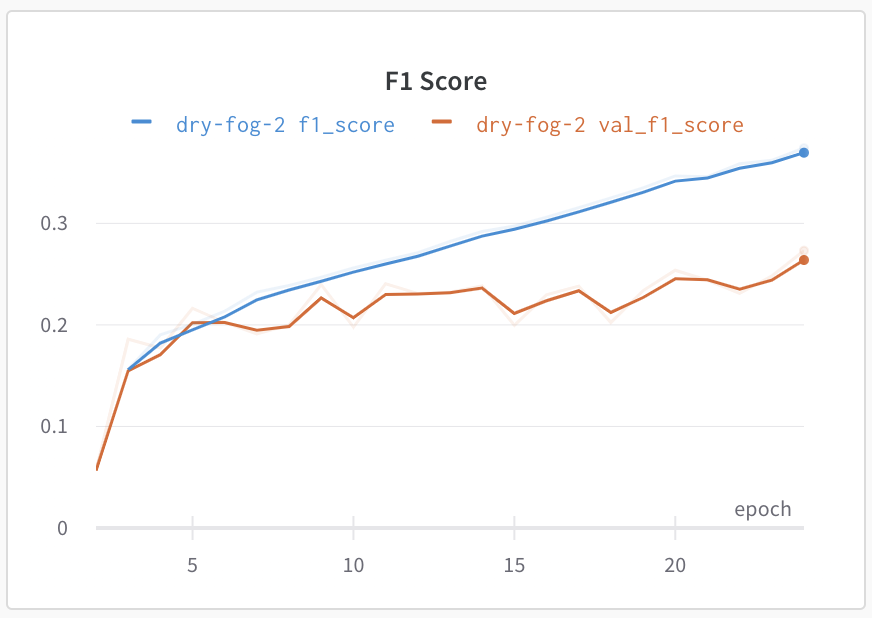

The F1 score on the training set is continuously growing, reaching more than 35%, while staying at around 20-25% at the validation set after ~12th epoch. 

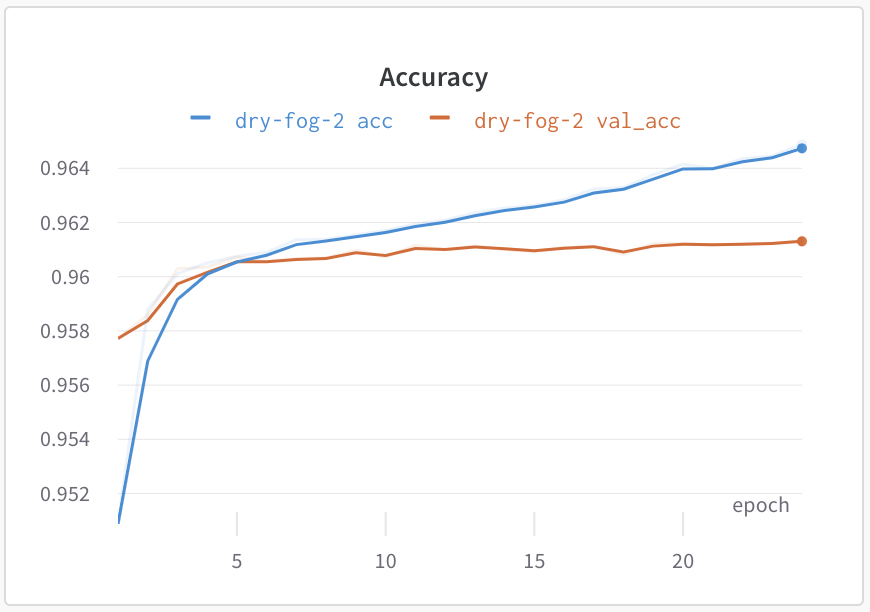

Same as F-1 score, accuracy on the validation set has plateaued, while on the training set it keeps improving (clear sign of overfitting).

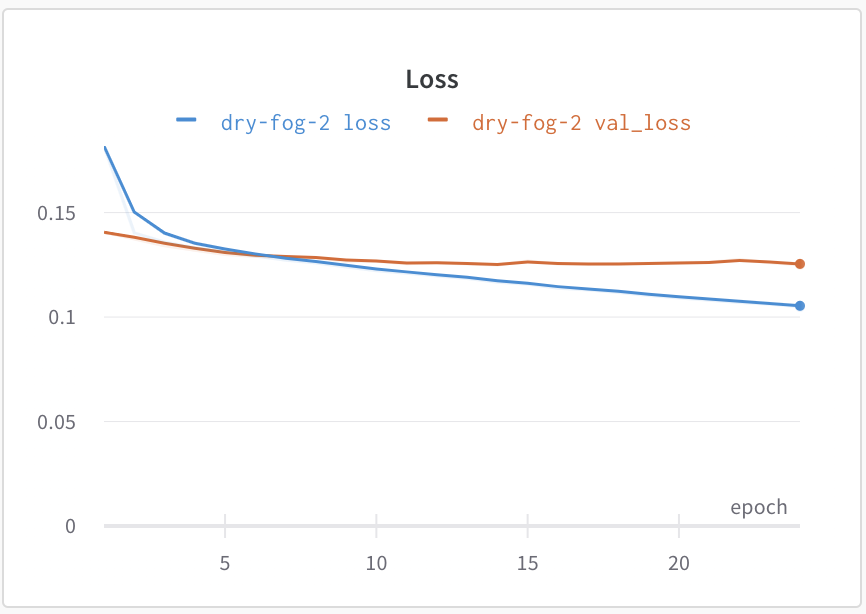

The same trend here. Makes sense.

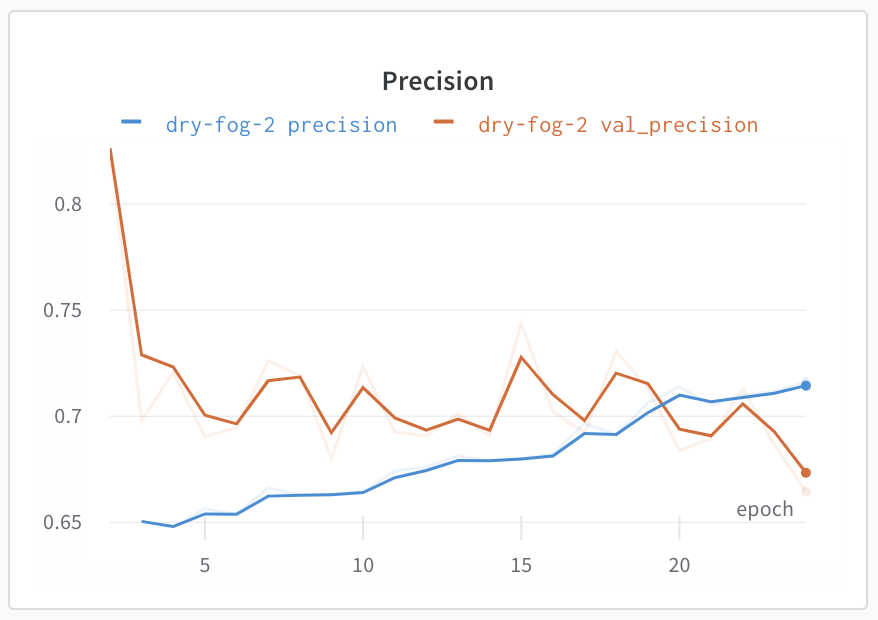

Precision is more noisy but roughly follows the same trend, with a dip in the validation precision in the final epochs.

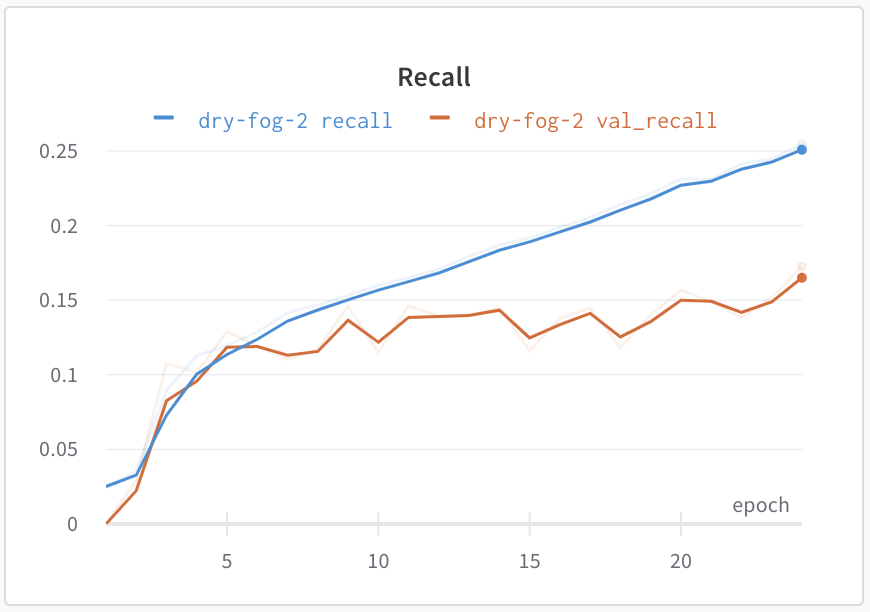

Opposite to precision, the recall on the validation set has improved in the final epochs. This hints at the fact that the model started giving higher probabilities to some tags, driving the True and False Positives up.